In [1]:
import datetime
from dateutil.parser import parse
import itertools
from itertools import product
import math
import matplotlib.pyplot as plt
from multiprocessing.dummy import Pool as ThreadPool
import nolds
import numpy as np
import os
import pandas as pd
import pathlib
from PreprocessFcns import *
import pywt
import random
import scipy
from scipy.fftpack import fft
from scipy.signal import butter, welch, filtfilt, resample
from scipy.stats import skew, kurtosis, entropy, pearsonr
import seaborn as sns
import sklearn
from sklearn import multiclass
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import LeaveOneGroupOut
import time
%matplotlib inline

In [2]:
# set path to folder containing clinic watch data
path = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
# set path to destination folder
dest = r'//FS2.smpp.local\\RTO\\CIS-PD Study\Watch Features Data'
#---------------------------------------------------------------------------------------------------------

In [3]:
VisitNumber = {
    '2 Weeks: Time 0'   : 0,
    '2 Weeks: Time 30'  : 1,
    '2 Weeks: Time 60'  : 2,
    '2 Weeks: Time 90'  : 3,
    '2 Weeks: Time 120' : 4,
    '2 Weeks: Time 150' : 5,
    '1 Month'           : 6
}

ClinicTasks = {
    'Stndg'    : 'Standing',
    'Wlkg'     : 'Walking',
    'WlkgCnt'  : 'Walking while counting',
    'FtnR'     : 'Finger to nose--right hand',
    'FtnL'     : 'Finger to nose--left hand',
    'RamR'     : 'Alternating right hand movements',
    'RamL'     : 'Alternating left hand movements',
    'SitStand' : 'Sit to stand',
    'Drwg'     : 'Drawing on a paper',
    'Typg'     : 'Typing on a computer keyboard',
    'NtsBts'   : 'Assembling nuts and bolts',
    'Drnkg'    : 'Taking a glass of water and drinking',
    'Sheets'   : 'Organizing sheets in a folder',
    'Fldg'     : 'Folding towels',
    'Sitng'    : 'Sitting'
}

In [10]:
## Correlate Task Symp Scors to Mean FFT Power in Freq Ranges
s_time = time.time()

# get the datafeatures file with features from each segmented clip
ClipData = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                                                                      'Tremor', 'Bradykinesia', 'Dyskinesia', 
                                                                                      'Overall']]

ClinicFreqData_mean = pd.DataFrame()
ClipFreqData = pd.DataFrame()
for clip in ClipData.iterrows():
    # open clip corresponding to each row of the datafeatures file
    clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                       str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + 
                                       clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                          parse_dates = ['Timestamp'])
#    # filter the three axes of the acceleration data
#     clipacc.loc[:, ['X', 'Y', 'Z']] = filterdata(clipacc[['X', 'Y', 'Z']])
    # calculat the magnitude of the acceleration data
    clipacc_mag = np.sqrt((clipacc.X)**2 + (clipacc.Y)**2 + (clipacc.Z)**2)
    L = len(clipacc_mag)
    # sampling frequency of the acceleration data
    Fs = L / (((pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                              (pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    # frequency domain spectrum of the clip - format into dataframe
    P1 = np.abs((fft(clipacc_mag))/L)[:int(L/2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1'] = P1
    
    # generate dataframe with mean value of power in various frequency ranges of spectrum
    ClipFreqData['SubjID'] = [int(clip[1]['SubjID'])]
    ClipFreqData['Visit'] = [clip[1]['Visit']]
    ClipFreqData['TaskAbb'] = [clip[1]['TaskAbb']]
    ClipFreqData['Clip'] = [clip[1]['Clip']]
    ClipFreqData['Tremor'] = [clip[1]['Tremor']]
    ClipFreqData['Bradykinesia'] = [clip[1]['Bradykinesia']]
    ClipFreqData['Dyskinesia'] = [clip[1]['Dyskinesia']]
    ClipFreqData['Overall'] = [clip[1]['Overall']]
    ClipFreqData['0-2'] = [np.mean(clipFFT.P1[(clipFFT.f >= 0) & (clipFFT.f <= 2)])]
    ClipFreqData['2-4'] = [np.mean(clipFFT.P1[(clipFFT.f >= 2) & (clipFFT.f <= 4)])]
    ClipFreqData['4-6'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 6)])]
    ClipFreqData['4-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 8)])] # thought to be optimal
    ClipFreqData['6-8'] = [np.mean(clipFFT.P1[(clipFFT.f >= 6) & (clipFFT.f <= 8)])]
    ClipFreqData['8-10'] = [np.mean(clipFFT.P1[(clipFFT.f >= 8) & (clipFFT.f <= 10)])]
    ClipFreqData['10-12'] = [np.mean(clipFFT.P1[(clipFFT.f >= 10) & (clipFFT.f <= 12)])]
    ClipFreqData['12-14'] = [np.mean(clipFFT.P1[(clipFFT.f >= 12) & (clipFFT.f <= 14)])]
    ClipFreqData['14-16'] = [np.mean(clipFFT.P1[(clipFFT.f >= 14) & (clipFFT.f <= 16)])]
    ClipFreqData['16-18'] = [np.mean(clipFFT.P1[(clipFFT.f >= 16) & (clipFFT.f <= 18)])]
    ClipFreqData['18-20'] = [np.mean(clipFFT.P1[(clipFFT.f >= 18) & (clipFFT.f <= 20)])]
    
    if ClinicFreqData_mean.empty:
        ClinicFreqData_mean = ClipFreqData
        continue
    ClinicFreqData_mean = pd.concat([ClinicFreqData_mean, ClipFreqData], ignore_index = True)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')
    
ClinicFreqData_mean.head()

0 hours 7 minutes 38 seconds


SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
0    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
1    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
2    1003      0   Drnkg     2     1.0           1.0         0.0      1.0   
3    1003      0   Drnkg     3     1.0           1.0         0.0      1.0   
4    1003      0   Drnkg     4     1.0           1.0         0.0      1.0   

        0-2       2-4       4-6       4-8       6-8      8-10     10-12  \
0  0.117553  0.009276  0.006647  0.008318  0.009989  0.010663  0.006057   
1  0.117553  0.009276  0.006647  0.008318  0.009989  0.010663  0.006057   
2  0.117573  0.010715  0.006772  0.008434  0.010095  0.010574  0.007566   
3  0.110109  0.006521  0.006090  0.005580  0.005069  0.007526  0.005632   
4  0.118951  0.009480  0.006083  0.006285  0.006486  0.012079  0.009111   

      12-14     14-16     16-18     18-20  
0  0.003209  0.002454  0.002158  0.002168  
1  0.003209  0.002454  0.002158  0.002168  
2  0.004077  0.002561  0.002274  0.002157  
3  0.003685  0.002246  0.001994  0.001118  
4  0.004384  0.003120  0.002554  0.001448

In [4]:
## Correlate Task Symp Scors to MAX FFT Power in Freq Ranges
s_time = time.time()

# get the datafeatures file with features from each segmented clip
ClipData = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                                                                      'Tremor', 'Bradykinesia', 'Dyskinesia', 
                                                                                      'Overall']]

ClinicFreqData_max = pd.DataFrame()
ClipFreqData = pd.DataFrame()
for clip in ClipData.iterrows():
    # open clip corresponding to each row of the datafeatures file
    clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                       str(int(clip[1]['SubjID'])) + '_' + str(clip[1]['Visit']) + '_' + 
                                       clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                          parse_dates = ['Timestamp'])
#     # filter the three axes of the acceleration data
#     clipacc.loc[:, ['X', 'Y', 'Z']] = filterdata(clipacc[['X', 'Y', 'Z']])
    # calculate the magnitude of the acceleration data
    clipacc_mag = np.sqrt((clipacc.X)**2 + (clipacc.Y)**2 + (clipacc.Z)**2)
    L = len(clipacc_mag)
    # sampling frequency of acceleration data
    Fs = L / (((pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[-1] - 
                              (pd.to_datetime(clipacc.Timestamp).values.astype(np.int64) // 10**6)[0]) / 1000)
    # get frequency domain spectrum for acceleration clip - organize in dataframe
    P1 = np.abs((fft(clipacc_mag))/L)[:int(L/2 + 1)]
    f = Fs * range(int(L / 2) + 1) / L
    clipFFT = pd.DataFrame()
    clipFFT['f'] = f
    clipFFT['P1'] = P1
    
    # create dataframe correlating metadata of each clip with maximum power in various ranges of frequency
    ClipFreqData['SubjID'] = [int(clip[1]['SubjID'])]
    ClipFreqData['Visit'] = [clip[1]['Visit']]
    ClipFreqData['TaskAbb'] = [clip[1]['TaskAbb']]
    ClipFreqData['Clip'] = [clip[1]['Clip']]
    ClipFreqData['Tremor'] = [clip[1]['Tremor']]
    ClipFreqData['Bradykinesia'] = [clip[1]['Bradykinesia']]
    ClipFreqData['Dyskinesia'] = [clip[1]['Dyskinesia']]
    ClipFreqData['Overall'] = [clip[1]['Overall']]
    ClipFreqData['0-2'] = [np.max(clipFFT.P1[(clipFFT.f >= 0) & (clipFFT.f <= 2)])]
    ClipFreqData['2-4'] = [np.max(clipFFT.P1[(clipFFT.f >= 2) & (clipFFT.f <= 4)])]
    ClipFreqData['4-6'] = [np.max(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 6)])]
    ClipFreqData['4-8'] = [np.max(clipFFT.P1[(clipFFT.f >= 4) & (clipFFT.f <= 8)])] # thought to be optimal
    ClipFreqData['6-8'] = [np.max(clipFFT.P1[(clipFFT.f >= 6) & (clipFFT.f <= 8)])]
    ClipFreqData['8-10'] = [np.max(clipFFT.P1[(clipFFT.f >= 8) & (clipFFT.f <= 10)])]
    ClipFreqData['10-12'] = [np.max(clipFFT.P1[(clipFFT.f >= 10) & (clipFFT.f <= 12)])]
    ClipFreqData['12-14'] = [np.max(clipFFT.P1[(clipFFT.f >= 12) & (clipFFT.f <= 14)])]
    ClipFreqData['14-16'] = [np.max(clipFFT.P1[(clipFFT.f >= 14) & (clipFFT.f <= 16)])]
    ClipFreqData['16-18'] = [np.max(clipFFT.P1[(clipFFT.f >= 16) & (clipFFT.f <= 18)])]
    ClipFreqData['18-20'] = [np.max(clipFFT.P1[(clipFFT.f >= 18) & (clipFFT.f <= 20)])]
    
    if ClinicFreqData_max.empty:
        ClinicFreqData_max = ClipFreqData
        continue
    ClinicFreqData_max = pd.concat([ClinicFreqData_max, ClipFreqData], ignore_index = True)

print(str(int(((time.time() - s_time) / 60) / 60)) + ' hours ' + 
      str(int(((time.time() - s_time) / 60) % 60)) + ' minutes ' + 
      str(int((time.time() - s_time) % 60)) + ' seconds')
    
ClinicFreqData_max.head()

0 hours 13 minutes 49 seconds


SubjID  Visit TaskAbb  Clip  Tremor  Bradykinesia  Dyskinesia  Overall  \
0    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
1    1003      0   Drnkg     1     1.0           1.0         0.0      1.0   
2    1003      0   Drnkg     2     1.0           1.0         0.0      1.0   
3    1003      0   Drnkg     3     1.0           1.0         0.0      1.0   
4    1003      0   Drnkg     4     1.0           1.0         0.0      1.0   

        0-2       2-4       4-6       4-8       6-8      8-10     10-12  \
0  0.994658  0.020447  0.009561  0.018055  0.018055  0.015770  0.009090   
1  0.994658  0.020447  0.009561  0.018055  0.018055  0.015770  0.009090   
2  0.999670  0.032626  0.009802  0.020130  0.020130  0.018341  0.012125   
3  0.999416  0.017086  0.011291  0.011291  0.009267  0.010358  0.011337   
4  0.999873  0.022652  0.010523  0.011603  0.011603  0.022738  0.017843   

      12-14     14-16     16-18     18-20  
0  0.005903  0.003960  0.003777  0.003262  
1  0.005903  0.003960  0.003777  0.003262  
2  0.007622  0.004917  0.003893  0.004288  
3  0.005376  0.003867  0.004508  0.001678  
4  0.006073  0.004539  0.005596  0.003168

In [6]:
def scoreTremFFT(FFTmetadata, task, freq, display):
    # FFTmetadata: clip-specific data of FFT powers (generated above) in freq ranges
    # task: Sitng or Stndg
    # freq: 0-2, 2-4, 4-6, 4-8, 6-8, 8-10, 10-12, 12-14, 14-16, 16-18, 18-20; 4-8 thought to be optimal
    # display: True or False
    
    pd.options.mode.chained_assignment = None # prevent warning output for SettingWithCopyWarning
    
    if display:
        print('___________________________________________________________________________')
        print(ClinicTasks[task])

    # isolate FFT data corresponding to task of interest
    CombTaskFreq = FFTmetadata[(FFTmetadata.TaskAbb == task)]

    # generate and plot ROC using power in provided freq range as 'prediction'
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(CombTaskFreq.Tremor.apply(lambda x: 1 if x > 0 else x).values, 
                                                     CombTaskFreq[freq].values) # must turn scores to bool for ROC
    if display:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate', fontsize = 12)
        plt.ylabel('True Positive Rate', fontsize = 12)
        plt.title('ROC Curve Power ' + freq + ' Hz', fontsize = 15)
        plt.show()

    # use the 'ideal' point of ROC to determine threshold power value in range for tremor determination
    ROCTremFFT = pd.DataFrame()
    ROCTremFFT['fpr'] = fpr
    ROCTremFFT['tpr'] = tpr
    ROCTremFFT['thresholds'] = thresholds
    ROCTremFFT['dist01'] = np.sqrt((1-ROCTremFFT.tpr)**2 + ROCTremFFT.fpr**2)
    TremPowerThreshold = ROCTremFFT.thresholds[ROCTremFFT.dist01 == min(ROCTremFFT.dist01)].values
    CombTaskFreq['FFTscore'] = CombTaskFreq[freq].apply(lambda x: 1 if x > float(TremPowerThreshold) else 0)
    CombTaskFreq = CombTaskFreq[['SubjID', 'Visit', 'TaskAbb', 'Clip', 
                                   'Tremor', 'FFTscore', freq]]
    
    # get and consolidate the condensed (by task - not clips) clinic metadata for correlation
    clinicpath = r'//FS2.smpp.local\\RTO\\CIS-PD Study\MJFF Curation\Finalized Dataset'
    clinicData = pd.read_csv(os.path.join(clinicpath, 'Metadata Tables', 'Table4.csv'))
    clinicTask = clinicData[(clinicData.TaskAbb == task)]
    TaskClinicData = pd.DataFrame()
    TaskData = pd.DataFrame()
    for task in clinicTask.iterrows():
        file = str(int(task[1]['SubjID'])) + '_' + str(VisitNumber[task[1]['Visit']]) + '_' + task[1]['TaskAbb']
        TaskData['SubjID'] = [int(task[1]['SubjID'])]
        TaskData['Visit'] = [VisitNumber[task[1]['Visit']]]
        TaskData['TaskAbb'] = [task[1]['TaskAbb']]
        if not type(task[1]['Side']) == str:
            continue
        TaskData['Tremor'] = [task[1]['Tremor - ' + task[1]['Side']]]
        if TaskClinicData.empty:
            TaskClinicData = TaskData
            continue
        TaskClinicData = pd.concat([TaskClinicData, TaskData], ignore_index = True)
        
    # score each task in Table 4 by the ratio of clips scored for tremor with total clips for that task
    ThresholdPred = pd.DataFrame()
    TaskPred = pd.DataFrame()
    for score in TaskClinicData.iterrows():
        totClips = len(CombTaskFreq[(CombTaskFreq.SubjID == score[1]['SubjID']) & 
                                     (CombTaskFreq.Visit == score[1]['Visit'])])
        if totClips == 0: # some of the metadata from Table 4 does not have acc clips associated
            continue
        TremFreqClips = len(CombTaskFreq[(CombTaskFreq.SubjID == score[1]['SubjID']) & 
                                         (CombTaskFreq.Visit == score[1]['Visit']) & 
                                         (CombTaskFreq.FFTscore == 1)])
        TaskPred['SubjID'] = [score[1]['SubjID']]
        TaskPred['Visit'] = [score[1]['Visit']]
        TaskPred['TaskAbb'] = [score[1]['TaskAbb']]
        TaskPred['Tremor'] = [int(score[1]['Tremor'])]
        TaskPred['FFTscoreRatio'] = [TremFreqClips / totClips]
        if ThresholdPred.empty:
            ThresholdPred = TaskPred
            continue
        ThresholdPred = pd.concat([ThresholdPred, TaskPred], ignore_index = True)

    # generate and plot ROC using ratio of power-predicted tremor clips to total clips as 'prediction'
    if display:
        fpr, tpr, thresholds = sklearn.metrics.roc_curve(ThresholdPred.Tremor.apply(lambda x: 1 if x > 0 else x).values,
                                                         ThresholdPred.FFTscoreRatio.values)
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate', fontsize = 12)
        plt.ylabel('True Positive Rate', fontsize = 12)
        plt.title('ROC Curve Threshold Scores', fontsize = 15)
        plt.show()
    
    #provide AUC of Threshold-predicted ratio tremor prediction for comparison
    RatioAUC = sklearn.metrics.roc_auc_score(ThresholdPred.Tremor.apply(lambda x: 1 if x > 0 else x).values,
                                                         ThresholdPred.FFTscoreRatio.values)
    if display:
        print(freq + ' Hz AUC')
        print(RatioAUC)
        print('___________________________________________________________________________')
    
    # CombTaskFreq includes bool prediction for presence/absence of tremor by clip
    # ThresholdPred contains ratio of tremor pred clips to total clips for each task with attached acc data
    # RatioAUC is the AUC value for ROC curve generated using the ratio of predicted trem clips to total clips
    return CombTaskFreq, ThresholdPred, RatioAUC

___________________________________________________________________________
Standing


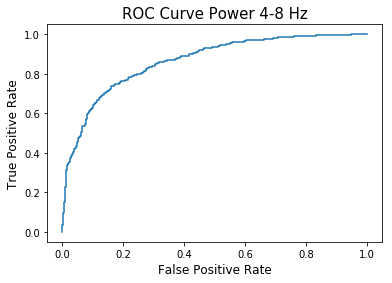

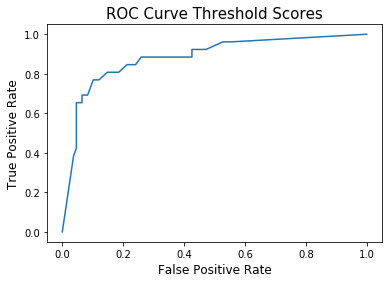

4-8 Hz AUC
0.8830128205128206
___________________________________________________________________________
___________________________________________________________________________
Sitting


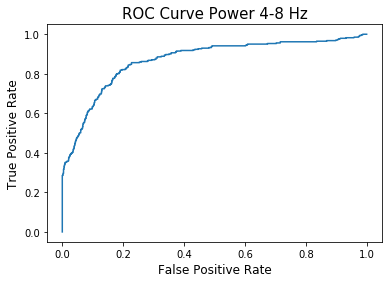

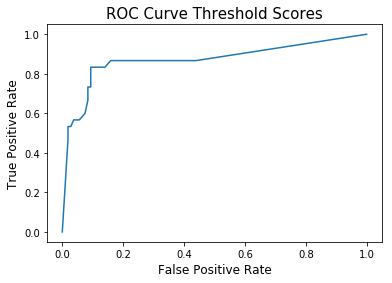

4-8 Hz AUC
0.8699376947040499
___________________________________________________________________________


In [7]:
StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', '4-8', True)
SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_max, 'Sitng', '4-8', True)

In [40]:
# filter DataFeatures file to remove clips with disagreement in scores
ClipDataFeatures = pd.read_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX.csv'))
print(len(ClipDataFeatures[(ClipDataFeatures.TaskAbb == 'Sitng') | (ClipDataFeatures.TaskAbb == 'Stndg')]))
confusedClipIdx = ((StndgClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x) != StndgClipFreq.FFTscore))
for clip in confusedClipIdx.index:
    if confusedClipIdx[clip]:
        ClipDataFeatures = ClipDataFeatures.drop([clip])
confusedClipIdx = ((SitngClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x) != SitngClipFreq.FFTscore))
for clip in confusedClipIdx.index:
    if confusedClipIdx[clip]:
        ClipDataFeatures = ClipDataFeatures.drop([clip])
# print number of clips remaining after removing clips whose FFT scores do not match symptomatic score
print(len(ClipDataFeatures[(ClipDataFeatures.TaskAbb == 'Sitng') | (ClipDataFeatures.TaskAbb == 'Stndg')]))
ClipDataFeatures.to_csv(os.path.join(dest, 'Clinic Data', 'ClinicDataFeaturesX_FFTscoreFilt.csv'), index = False)

3053
2455


482482


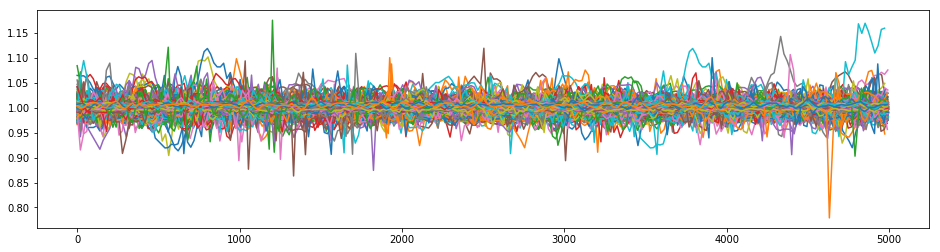

0.004732741649259689
0.08082132917876517


In [22]:
# analysis for choosing thresholds for anomaly detection
# get all clips characteristically non-symptomatic that also have FFT score characteristic of normality
NormSSClips = pd.concat([StndgClipFreq[(StndgClipFreq.Tremor == 0) & (StndgClipFreq.FFTscore == 0)], 
                         SitngClipFreq[(SitngClipFreq.Tremor == 0) & (SitngClipFreq.FFTscore == 0)]])
plt.figure(figsize = (16, 4))
NormSSAcc = []
allRMSE = []
for clip in NormSSClips.iterrows():
    ClipAccFile = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                           str(clip[1]['SubjID']) + '_' + str(clip[1]['Visit']) + '_' + 
                                           clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                              parse_dates = ['Timestamp'])[['Timestamp', 'X', 'Y', 'Z']]
    ClipMag = np.sqrt((ClipAccFile.X)**2 + (ClipAccFile.Y)**2 + (ClipAccFile.Z)**2)
    RMSE = np.sqrt(np.mean((ClipMag - np.mean(ClipMag))**2))
    NormSSAcc = NormSSAcc + list(ClipMag.values)
    allRMSE = allRMSE + [RMSE]
    ClipAccFile['Mag'] = ClipMag
    
    ClipAccFile['NormTime'] = ((pd.to_datetime(ClipAccFile.Timestamp).values.astype(np.int64) // 10**6) - 
                               (pd.to_datetime(ClipAccFile.Timestamp).values.astype(np.int64) // 10**6)[0])
    # plot all the 'normal' clips (by original score and FFT analysis) on top of one another
    plt.plot(ClipAccFile.NormTime, ClipAccFile.Mag)
# length of the full list of acceleration data points of all of these clips considered
print(len(NormSSAcc))
plt.show()

# average value of the root mean squared error across all of these clips considered
print(np.mean(allRMSE))
# range of acceleration data points between the two percentiles specified
print(np.percentile(NormSSAcc, 99.9) - np.percentile(NormSSAcc, 0.1))

In [35]:
# determine performance using the different frequency ranges via AUC - Standing
FreqRange = []
AUC = []
for freq in ClinicFreqData_max.columns[8:]:
    StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', freq, False)
    FreqRange = FreqRange + [freq]
    AUC = AUC + [StndgAUC]
pd.DataFrame({'FreqRange': FreqRange, 'AUC': AUC})

FreqRange       AUC
0        0-2  0.652244
1        2-4  0.875178
2        4-6  0.835470
3        4-8  0.883013
4        6-8  0.870905
5       8-10  0.848291
6      10-12  0.899929
7      12-14  0.886040
8      14-16  0.873575
9      16-18  0.887286
10     18-20  0.880698

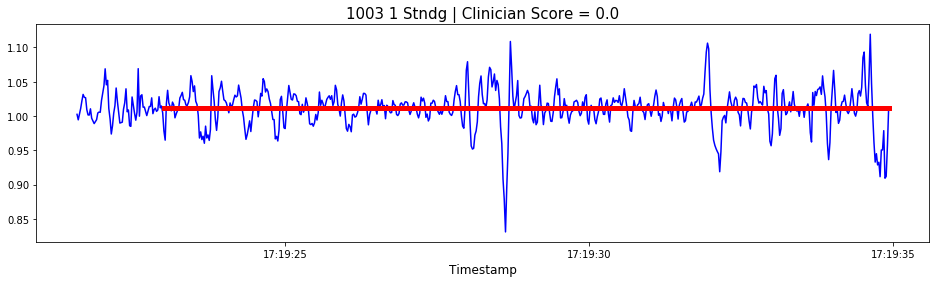

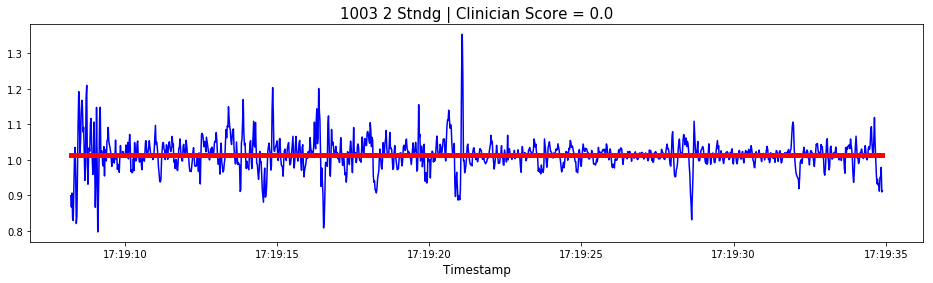

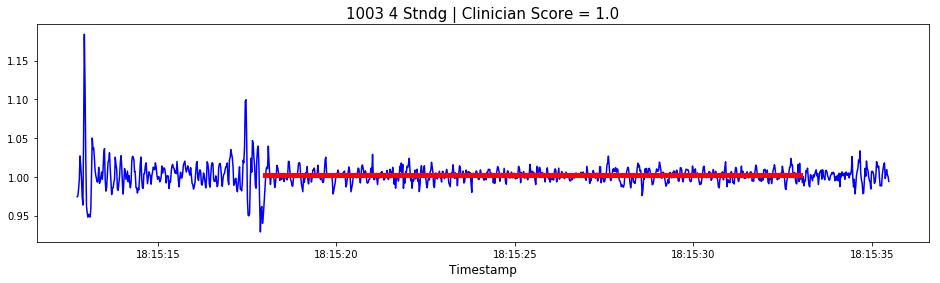

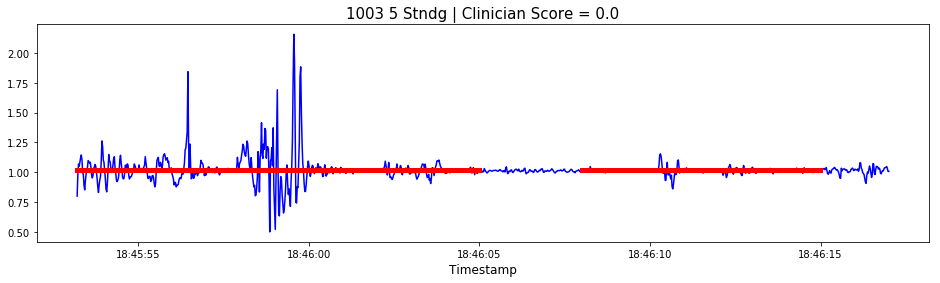

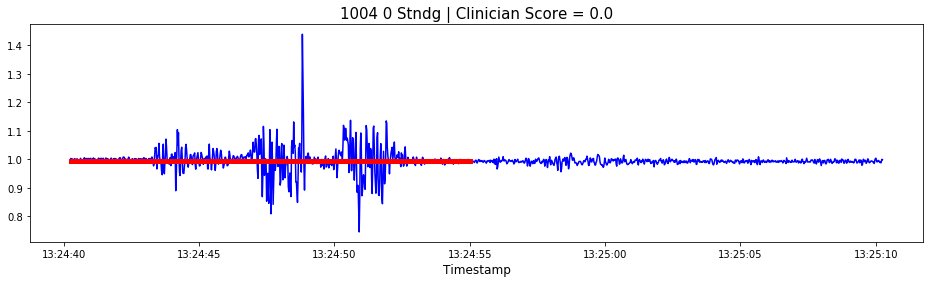

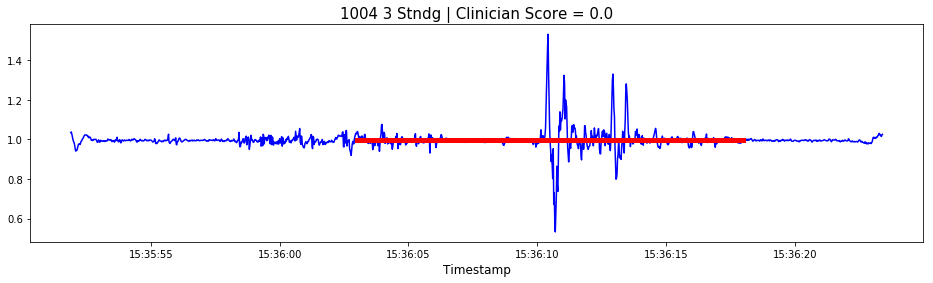

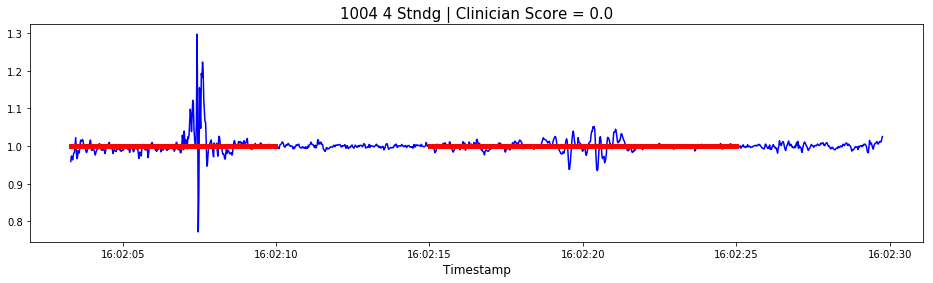

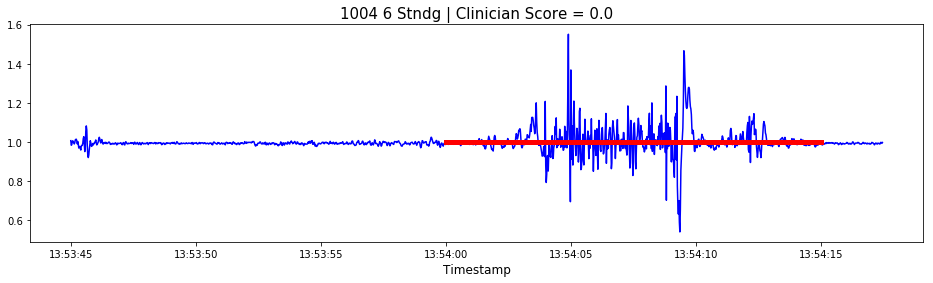

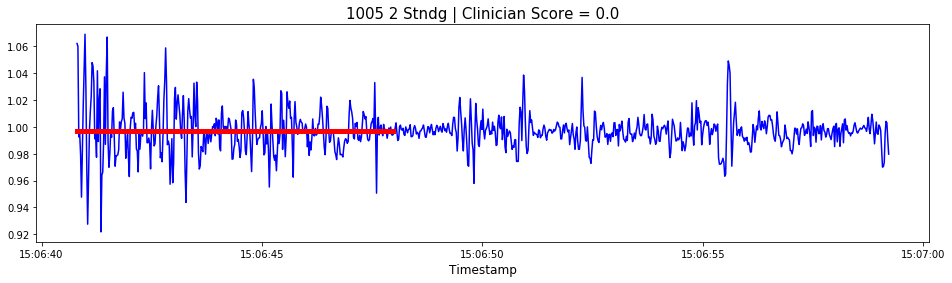

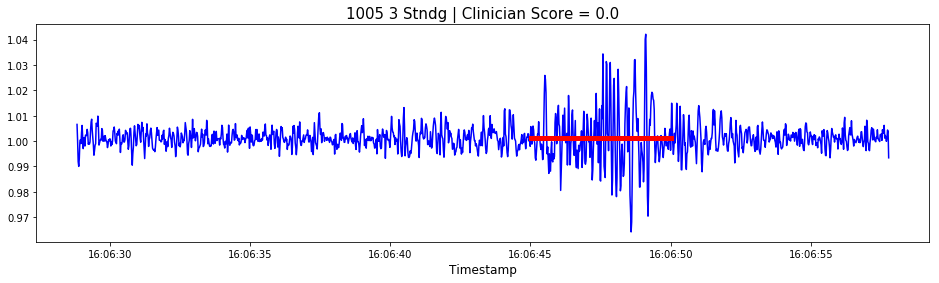

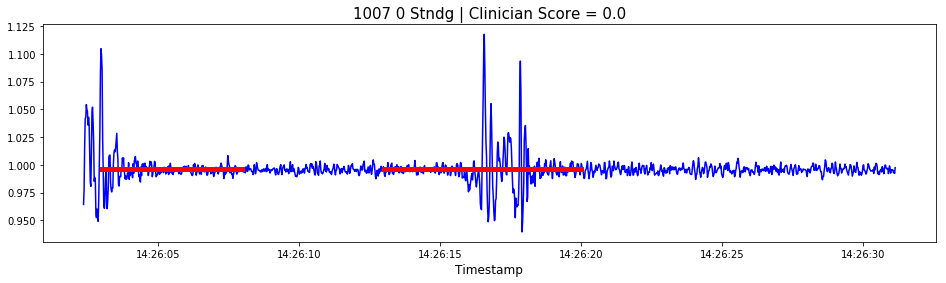

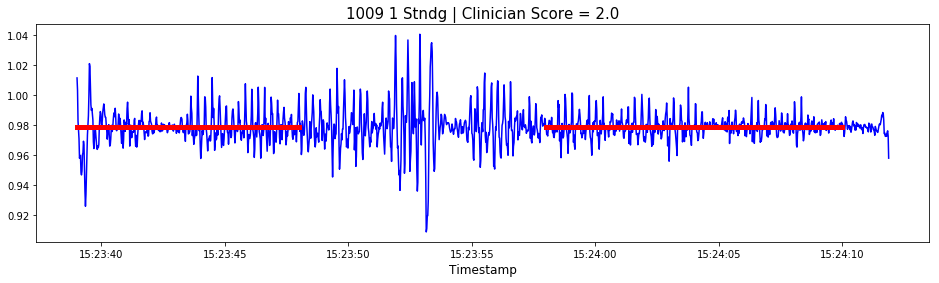

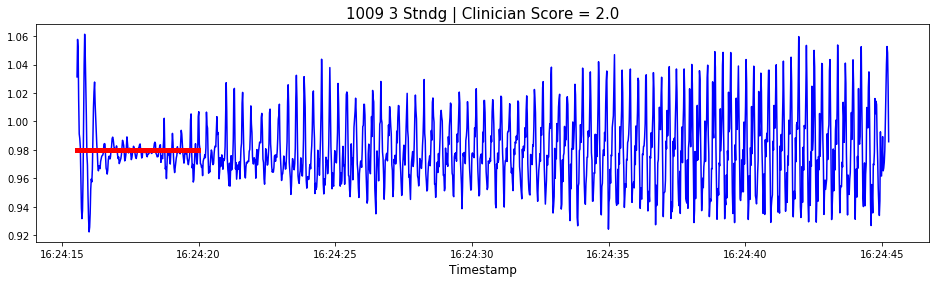

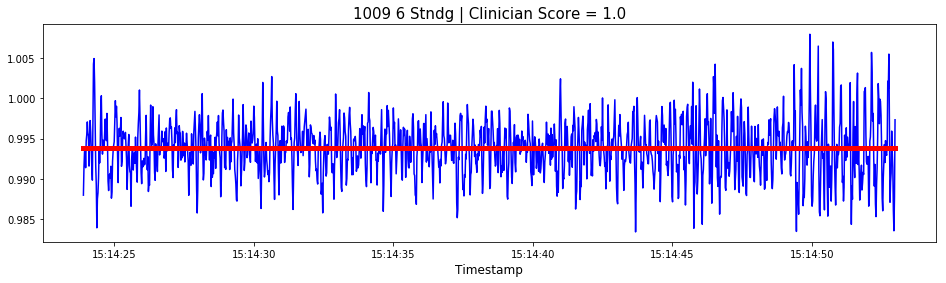

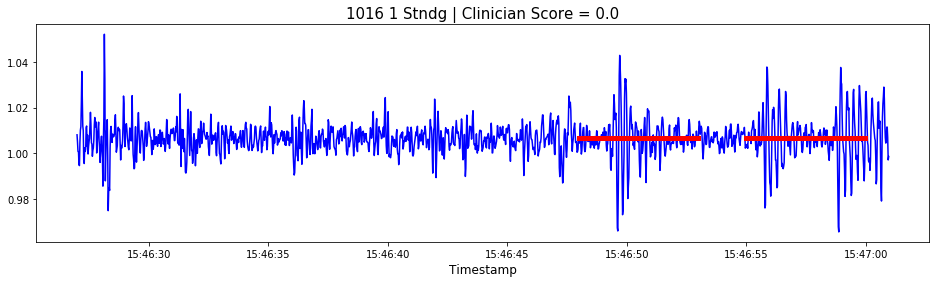

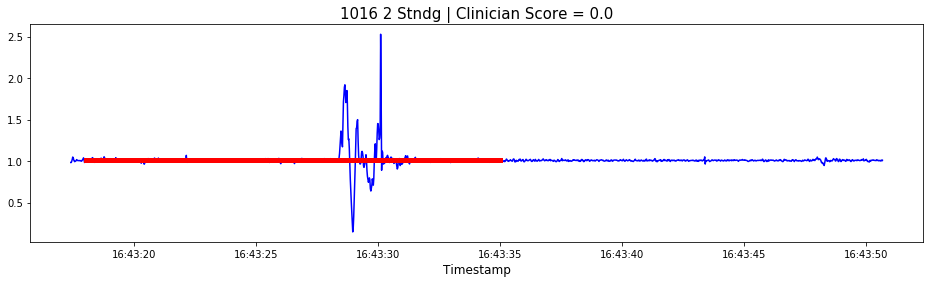

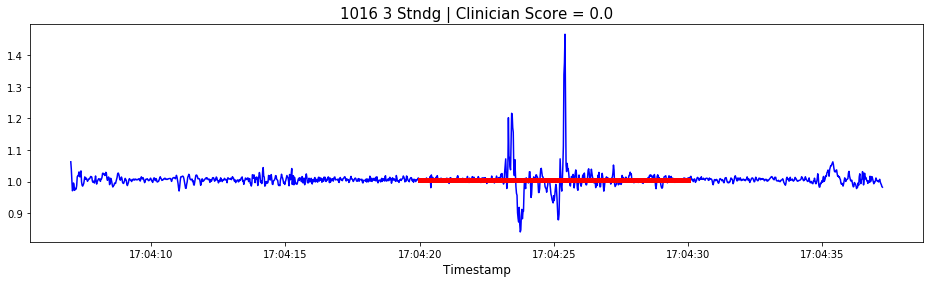

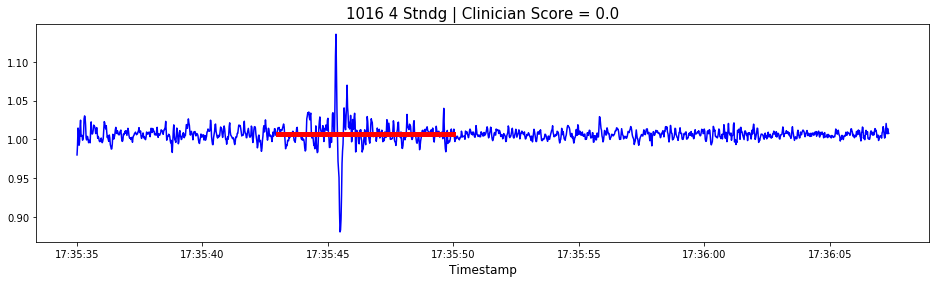

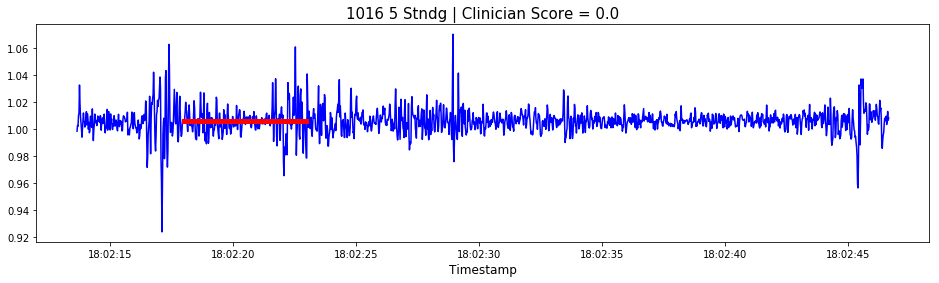

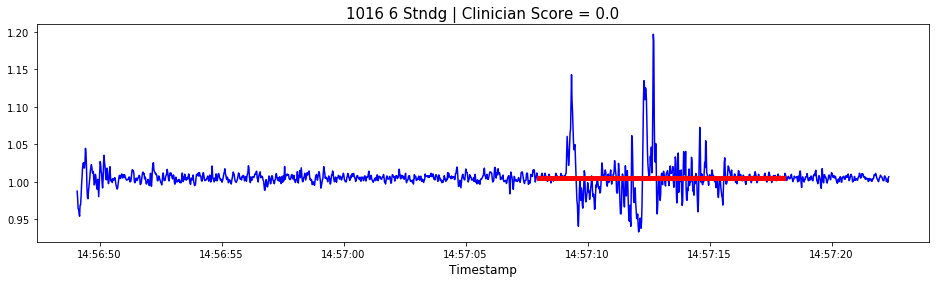

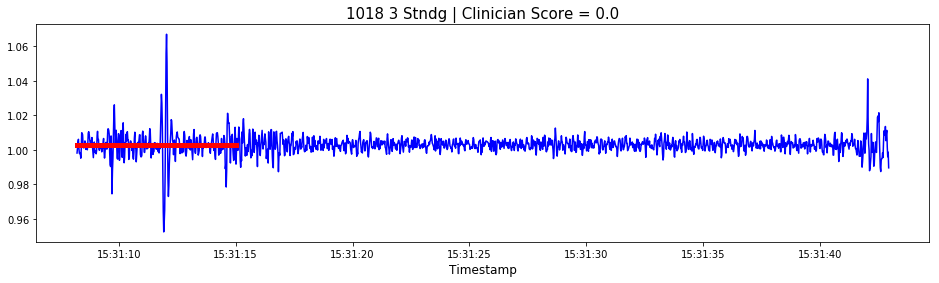

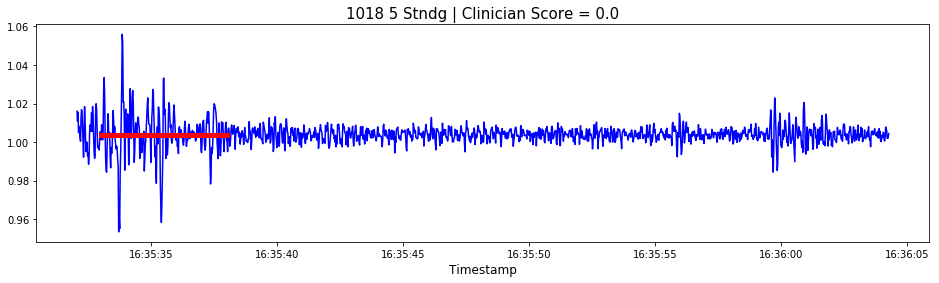

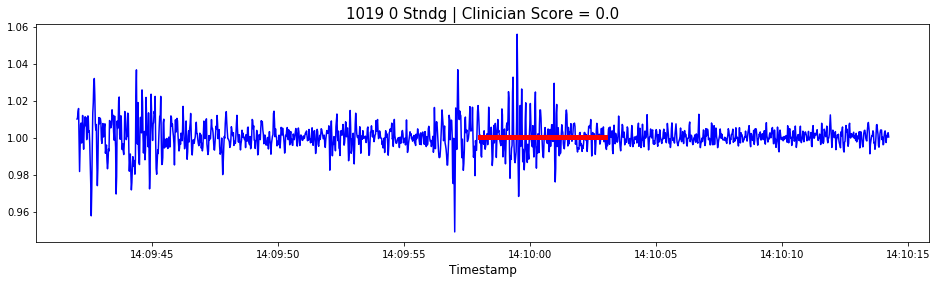

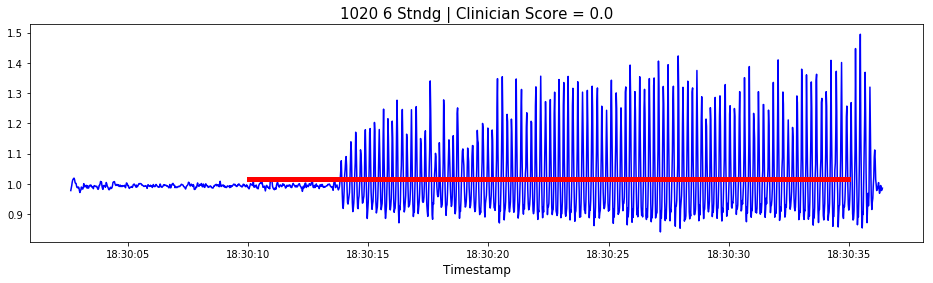

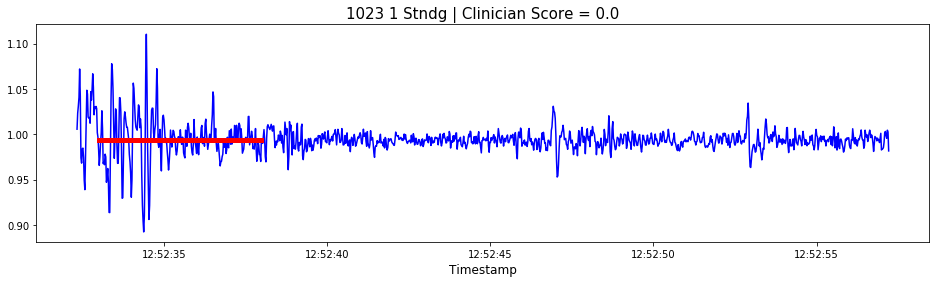

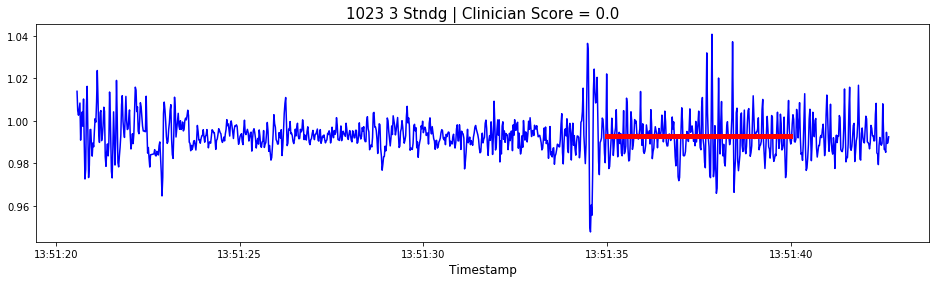

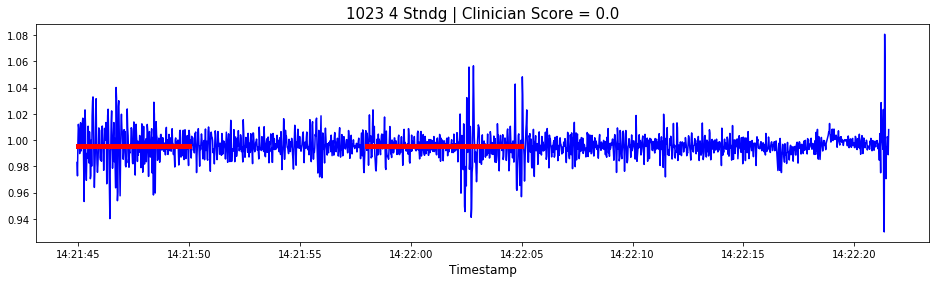

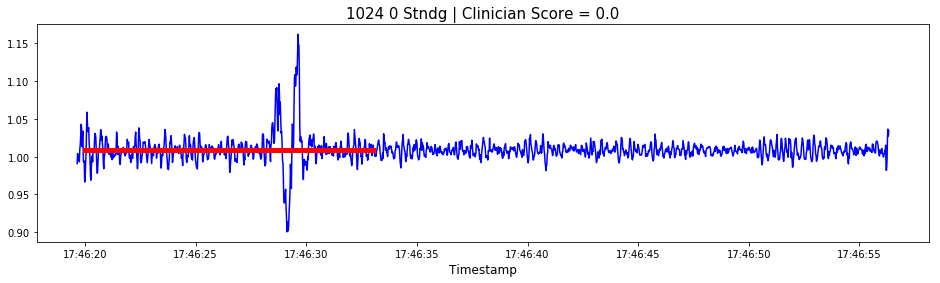

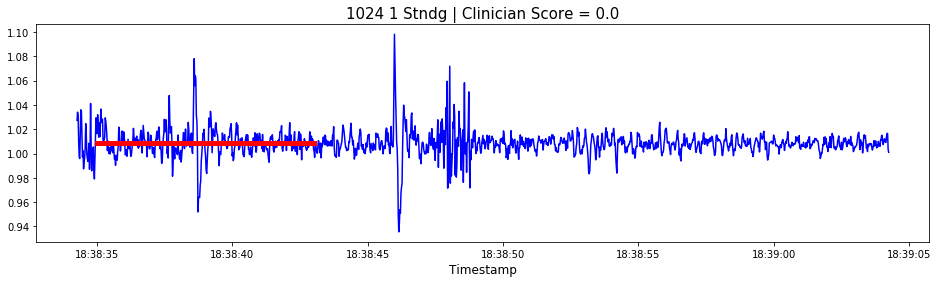

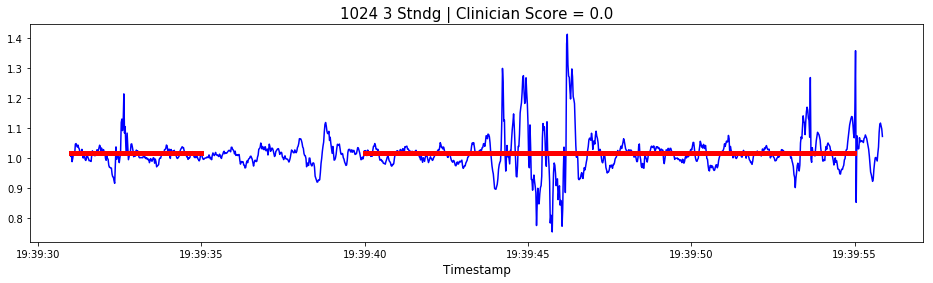

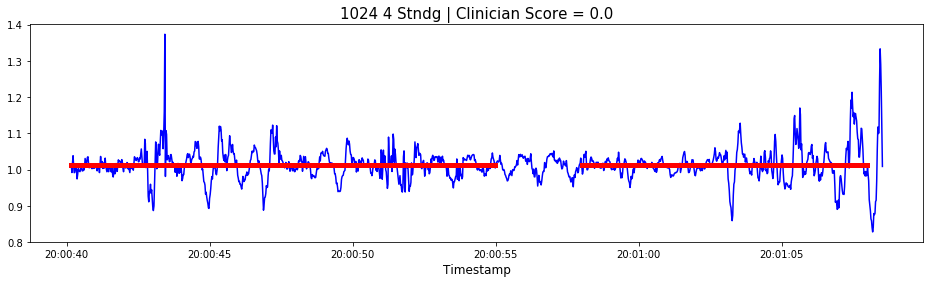

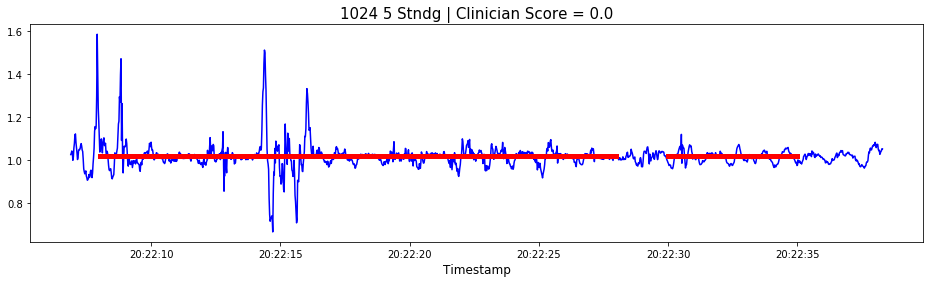

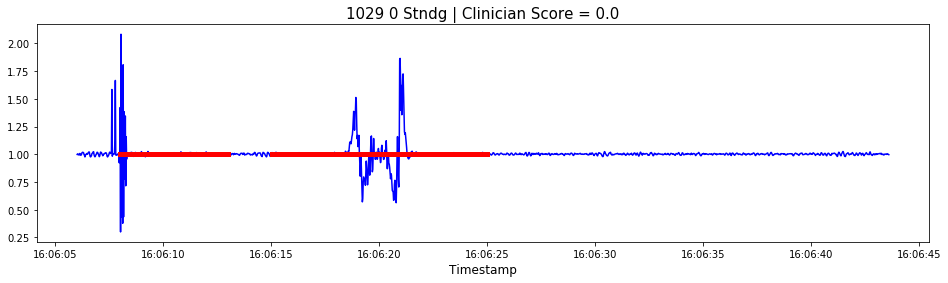

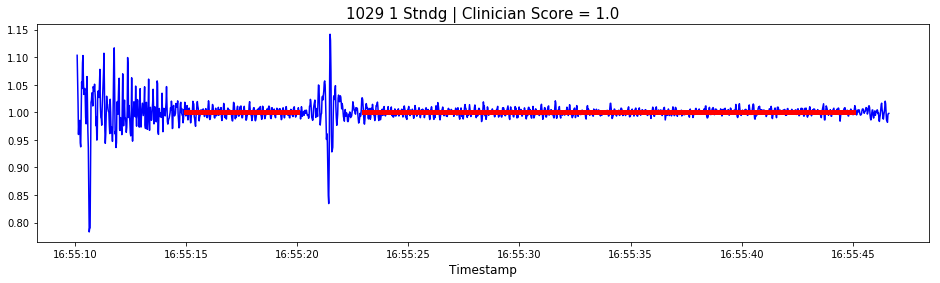

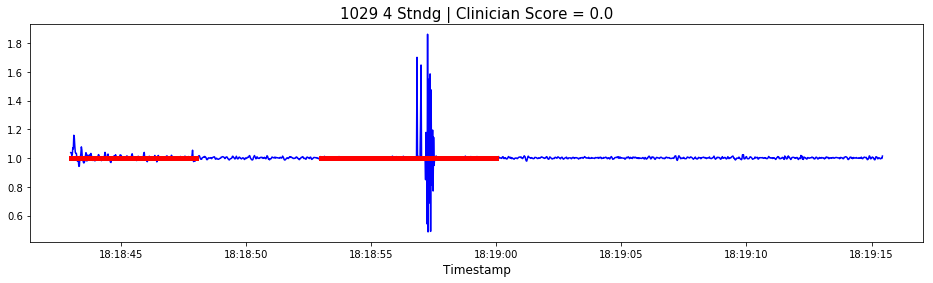

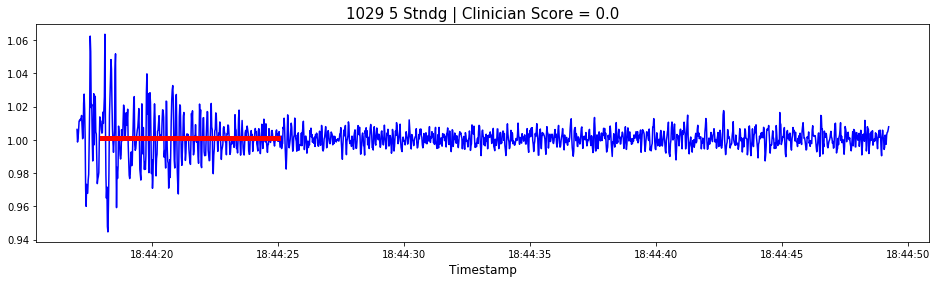

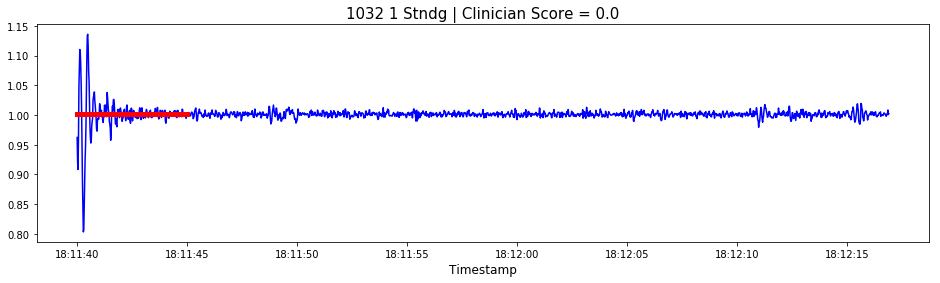

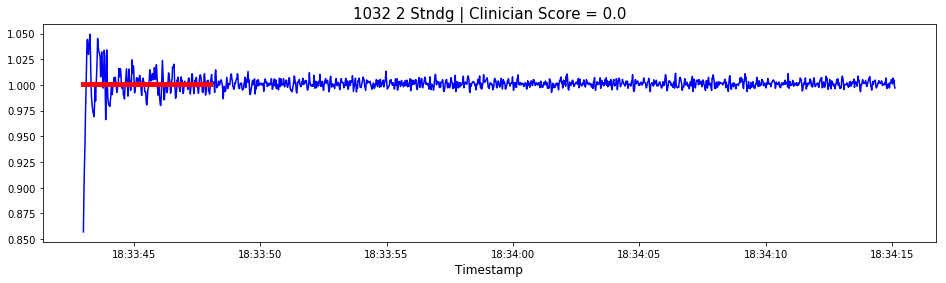

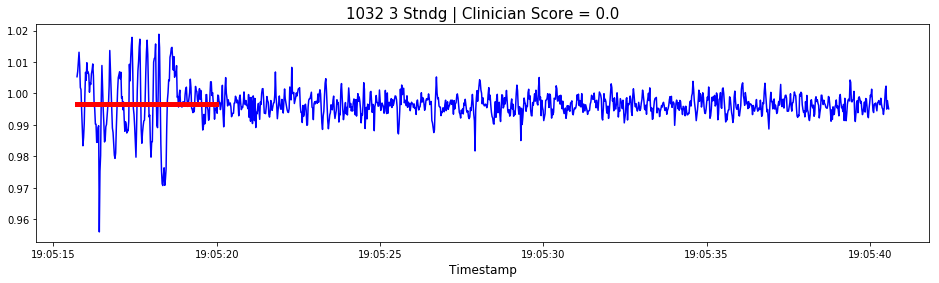

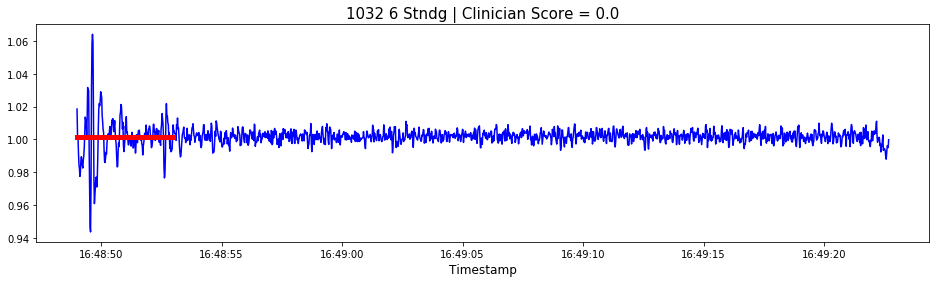

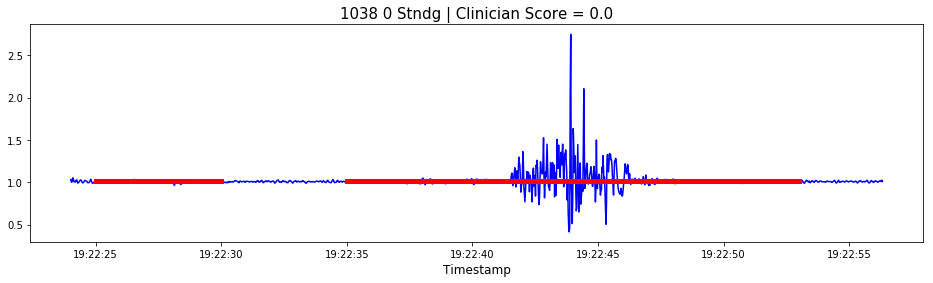

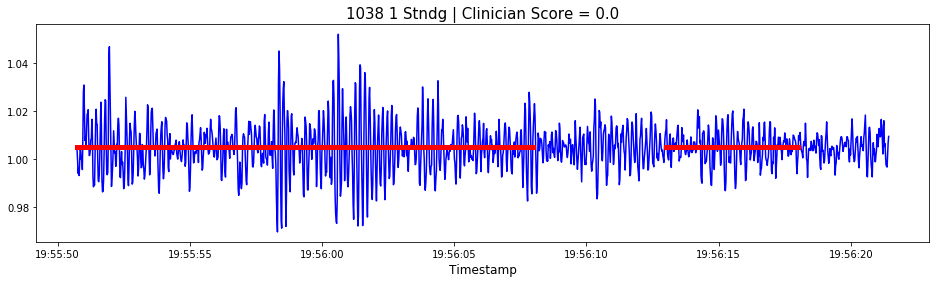

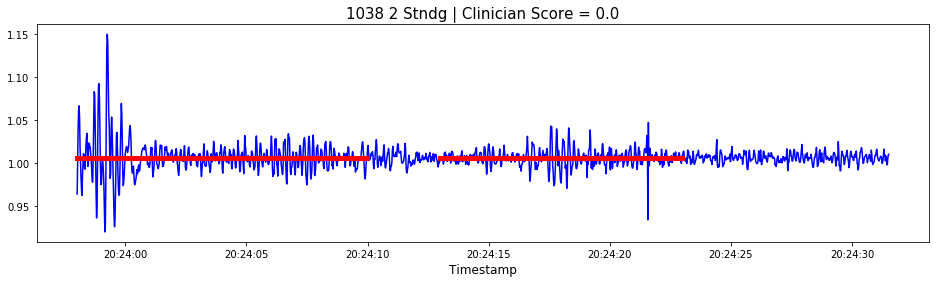

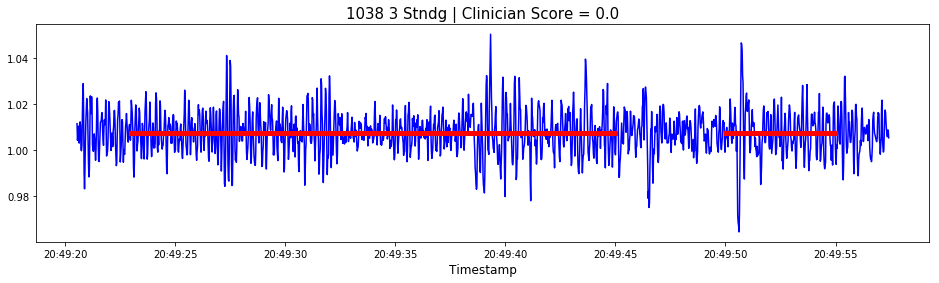

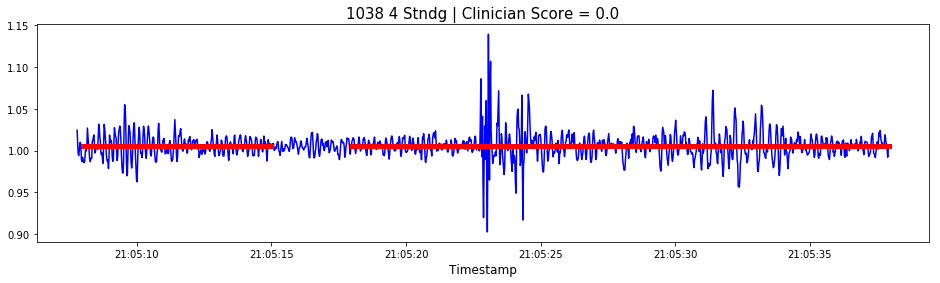

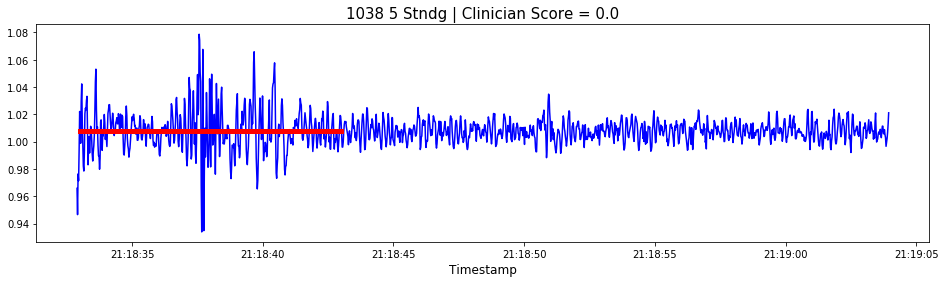

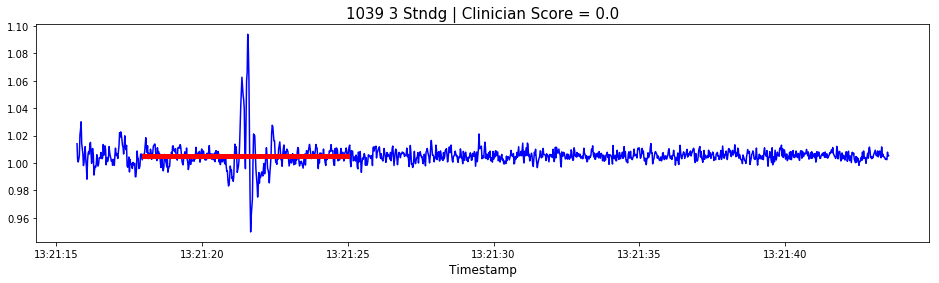

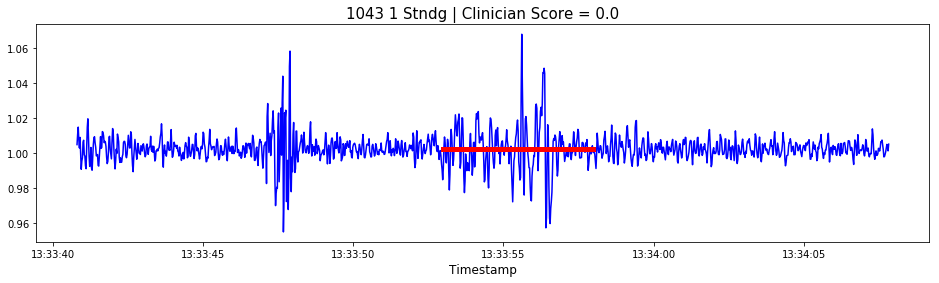

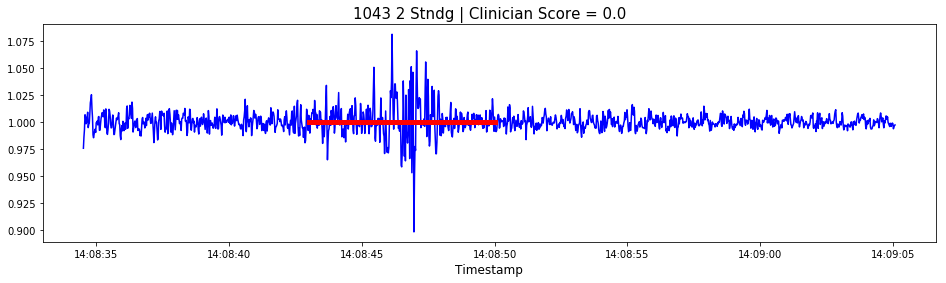

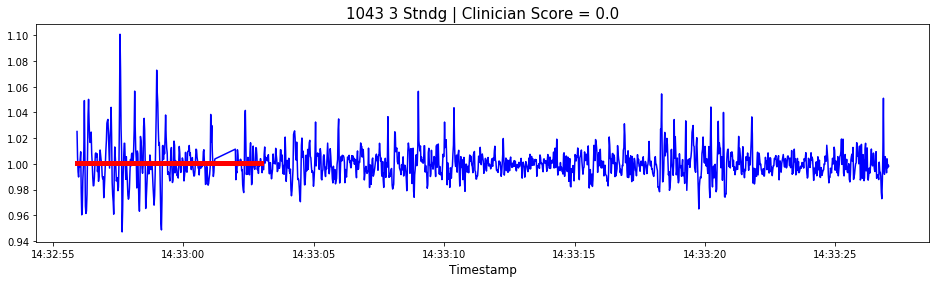

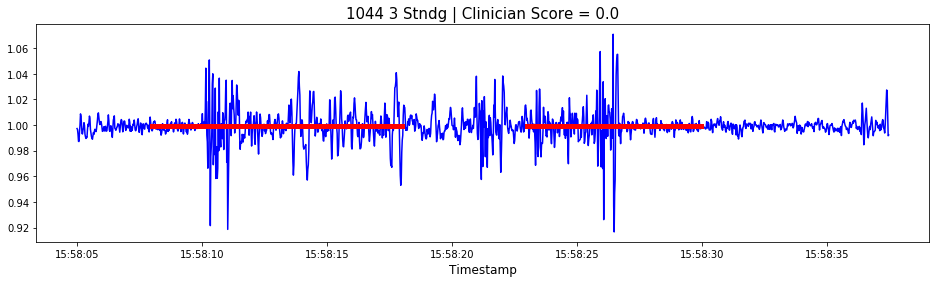

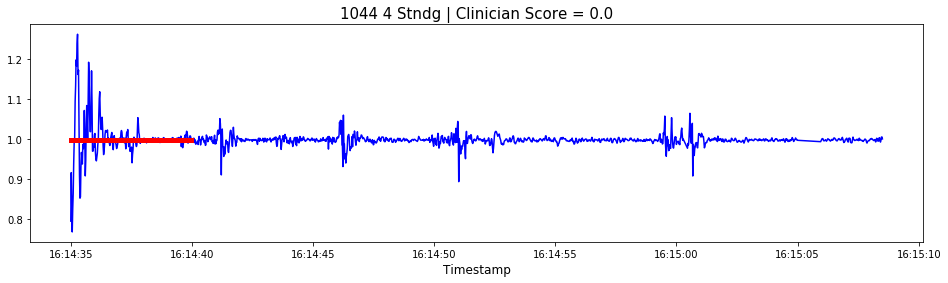

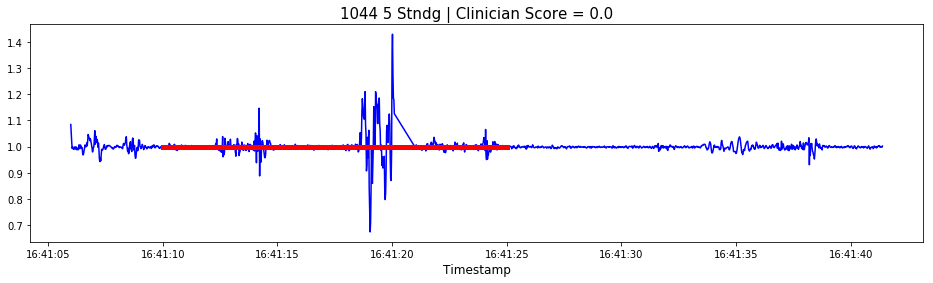

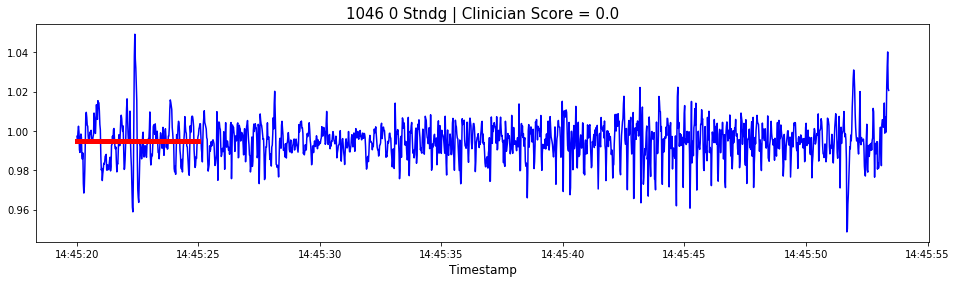

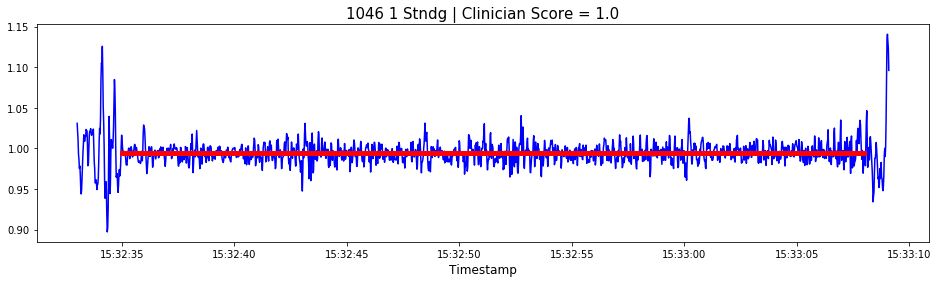

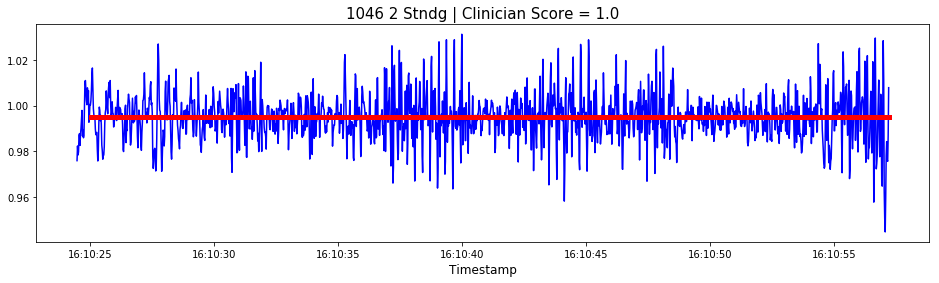

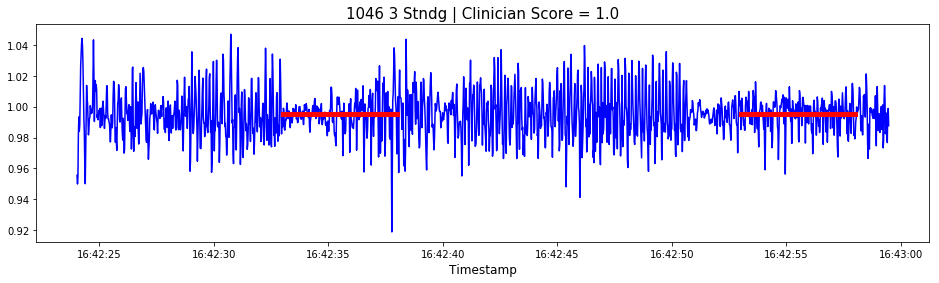

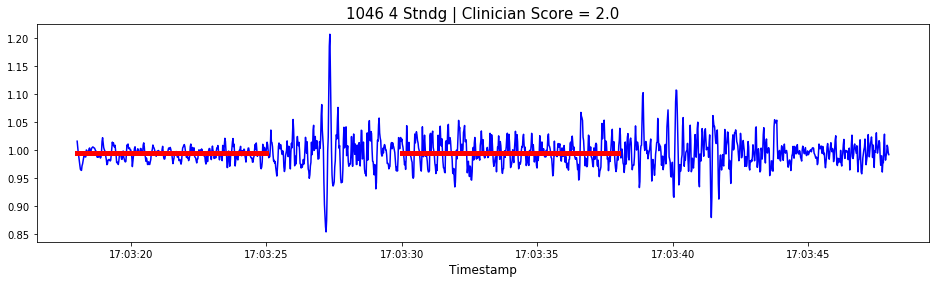

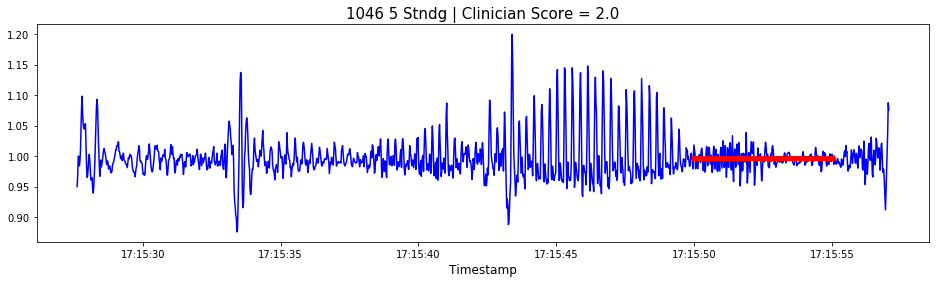

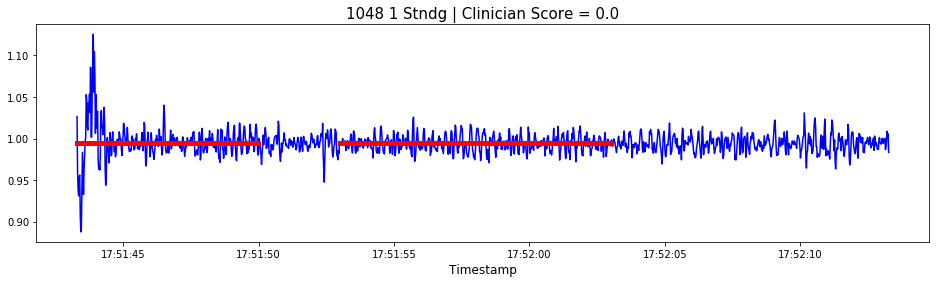

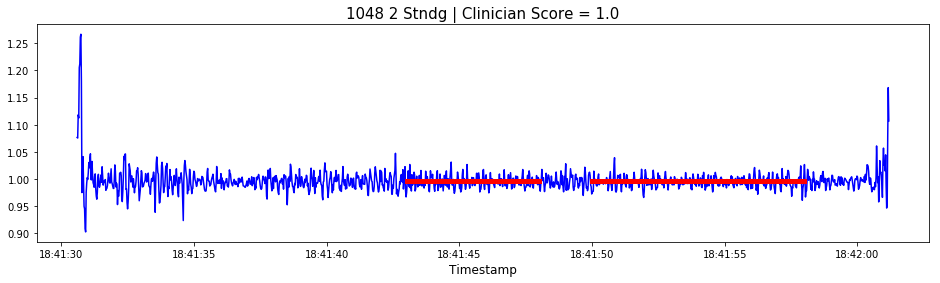

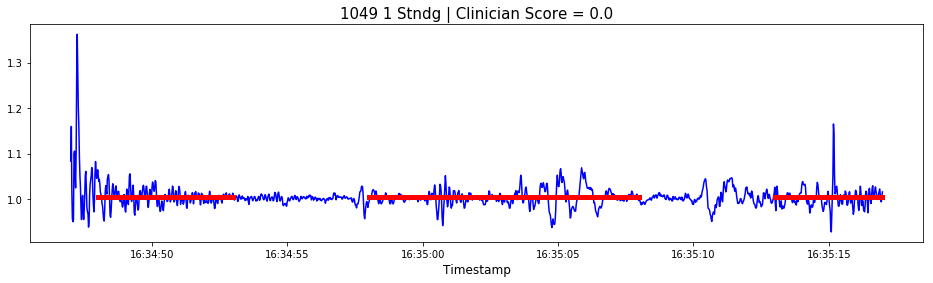

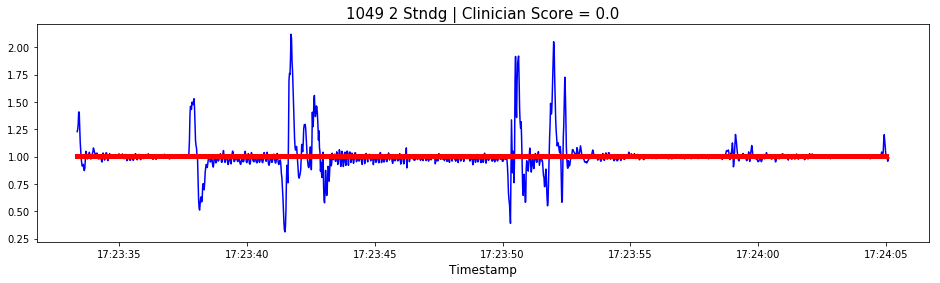

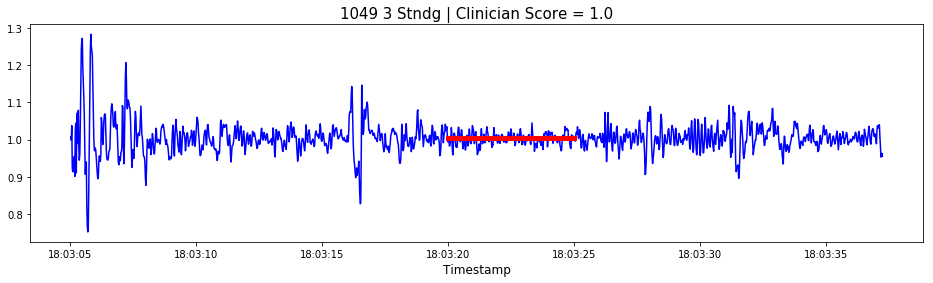

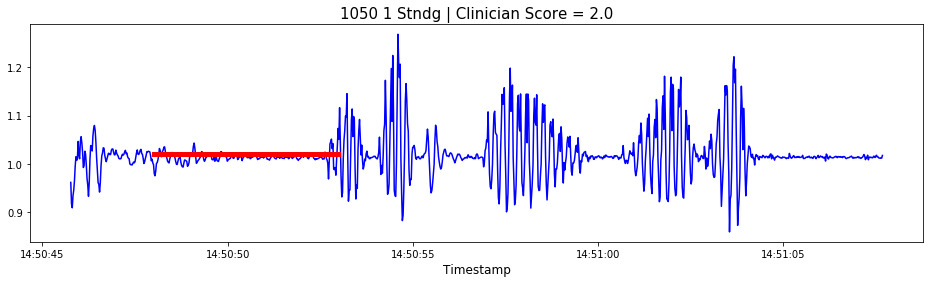

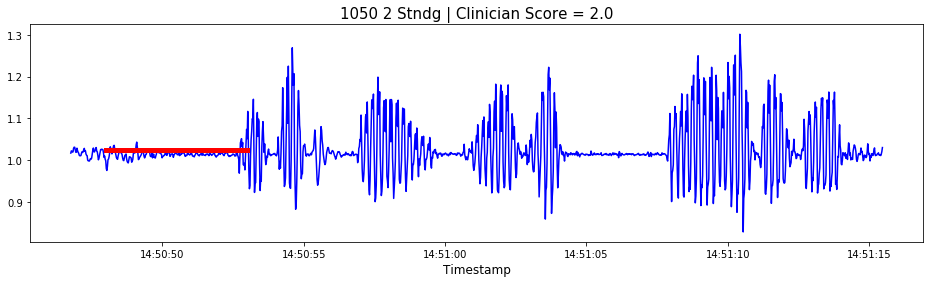

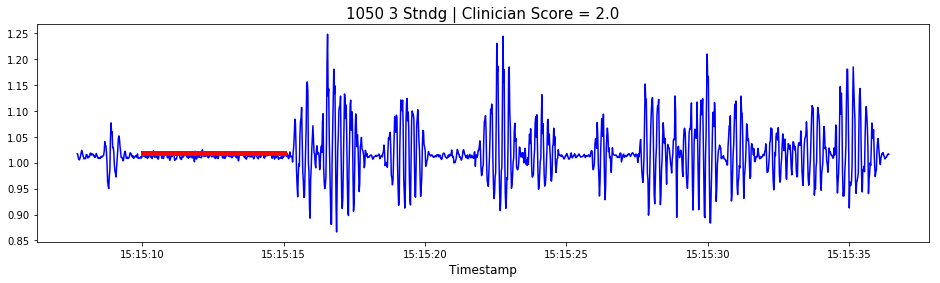

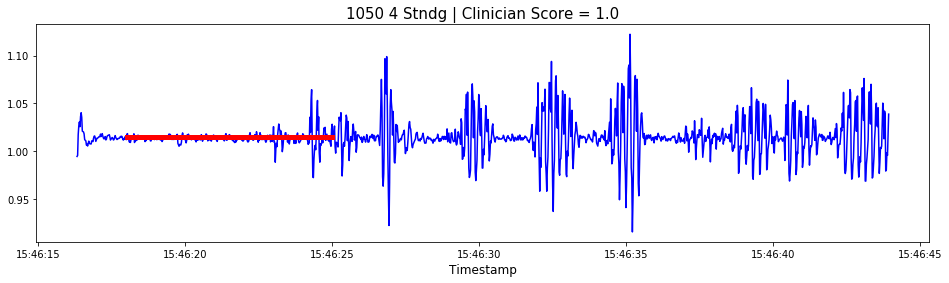

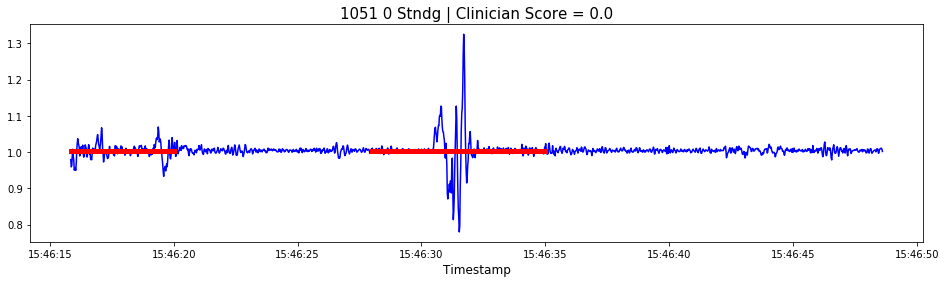

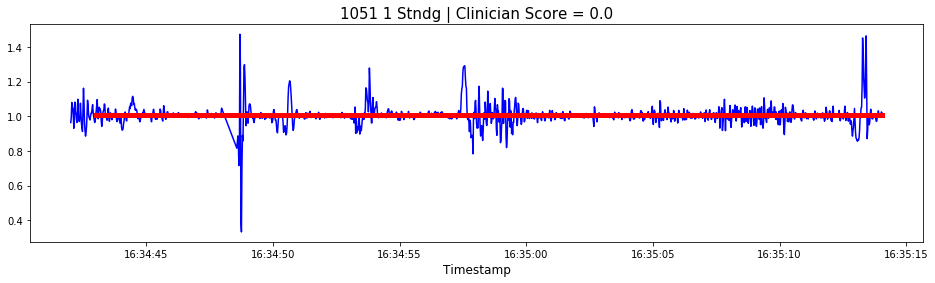

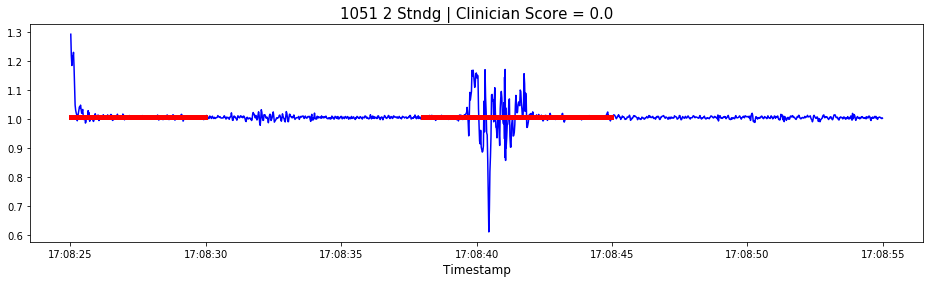

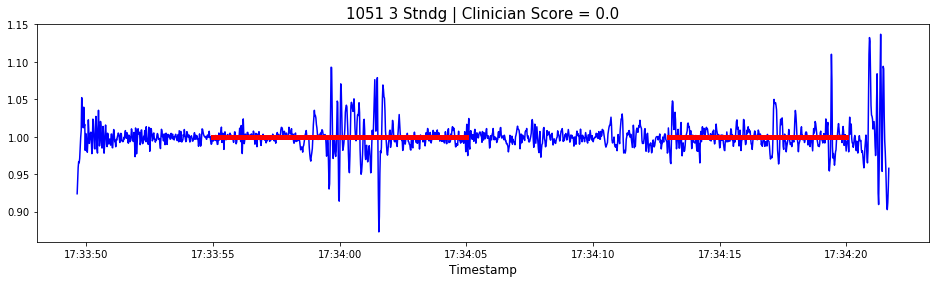

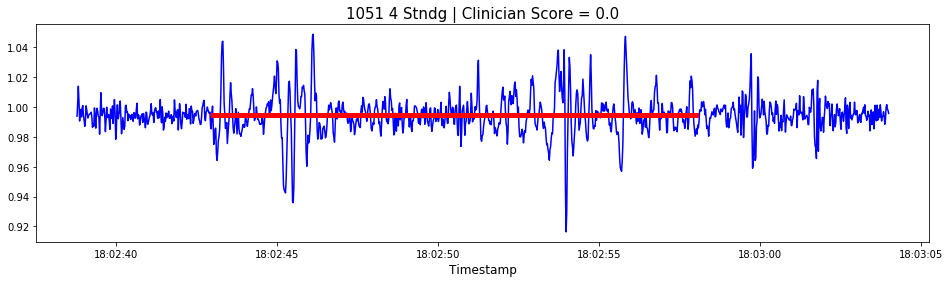

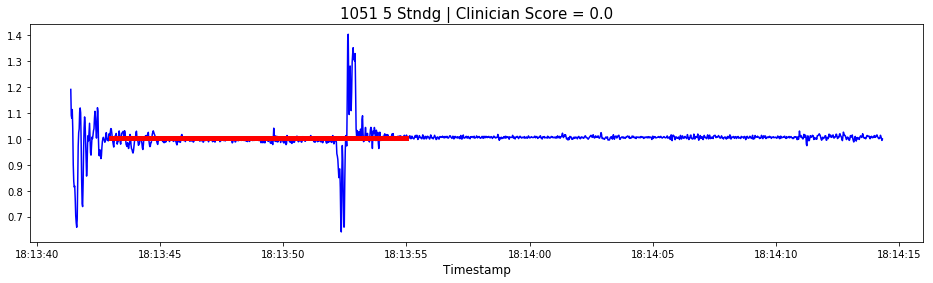

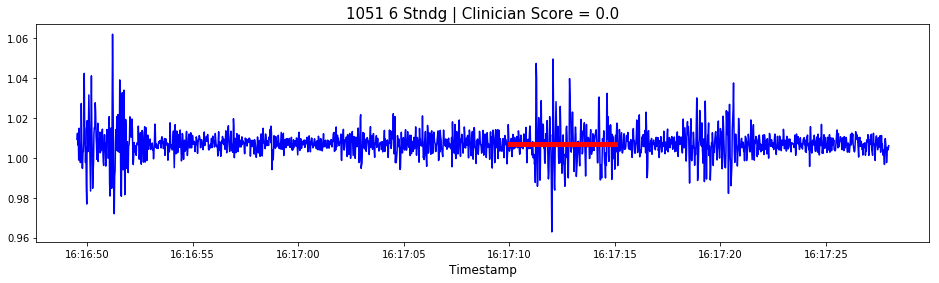

In [36]:
# plot all full task signals containing clips thought to be attached to an improper score for tremor
StndgClipFreq, StndgTaskPred, StndgAUC = scoreTremFFT(ClinicFreqData_max, 'Stndg', '4-8', False)
FalseLabClips = StndgClipFreq[StndgClipFreq.FFTscore != StndgClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x)]
for sub in FalseLabClips.SubjID.unique():
    SFalseLab = FalseLabClips[FalseLabClips.SubjID == sub]
    for visit in SFalseLab.Visit.unique():
        SVFalseLab = SFalseLab[SFalseLab.Visit == visit]
        accdata = pd.read_csv(os.path.join(path, 'TaskAcc', 
                                           str(sub) + '_' + str(visit) + '_' + SVFalseLab.TaskAbb.iloc[-1] + '.csv'), 
                              parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
#         accdata.loc[:, ['x', 'y', 'z']] = filterdata(accdata[['x', 'y', 'z']])
        acc_mag = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
        SVClips = pd.DataFrame()
        plt.figure(figsize = (16, 4))
        plt.plot(accdata.timestamp, acc_mag, 'b')
        for clip in SVFalseLab.iterrows():
            clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                str(sub) + '_' + str(visit) + '_' + 
                                                clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                   parse_dates = ['Timestamp'])[['Timestamp']]
            plt.plot(clipacc.values, [np.mean(acc_mag)] * len(clipacc.values), 'r', linewidth = 5)
        plt.xlabel('Timestamp', fontsize = 12)
        plt.title(str(sub) + ' ' + str(visit) + ' ' + SVFalseLab.TaskAbb.iloc[-1] + ' | '
                  'Clinician Score = ' + str(SVFalseLab.Tremor.iloc[-1]), fontsize = 15)
        plt.show()
        
# red line indicates position of 'falsely labeled' clips of the data

In [37]:
# determine performance using the different frequency ranges via AUC - Sitting
FreqRange = []
AUC = []
for freq in ClinicFreqData_max.columns[8:]:
    SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_max, 'Sitng', freq, False)
    FreqRange = FreqRange + [freq]
    AUC = AUC + [SitngAUC]
pd.DataFrame({'FreqRange': FreqRange, 'AUC': AUC})

FreqRange       AUC
0        0-2  0.640810
1        2-4  0.837227
2        4-6  0.843614
3        4-8  0.869938
4        6-8  0.844548
5       8-10  0.875078
6      10-12  0.838318
7      12-14  0.822118
8      14-16  0.829128
9      16-18  0.839252
10     18-20  0.822274

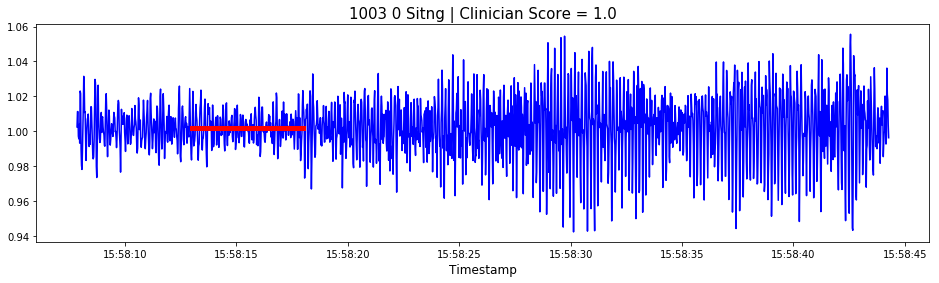

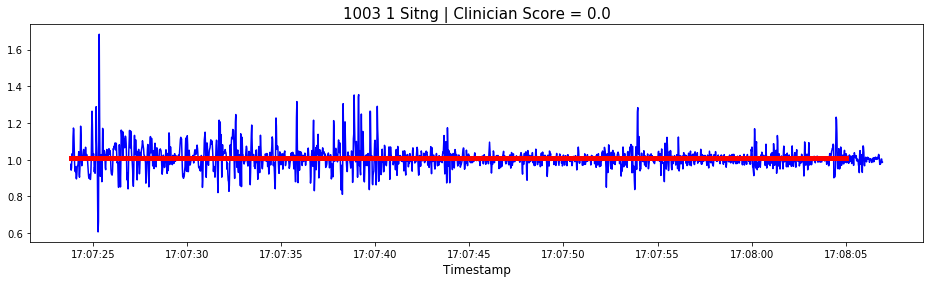

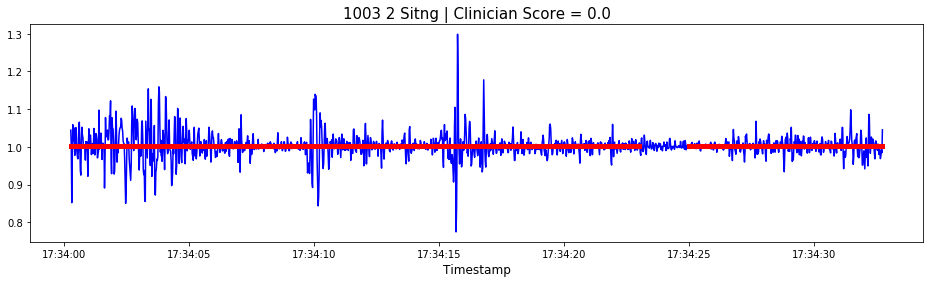

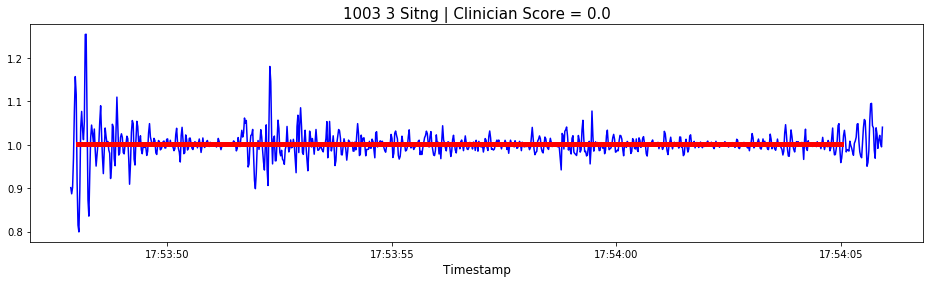

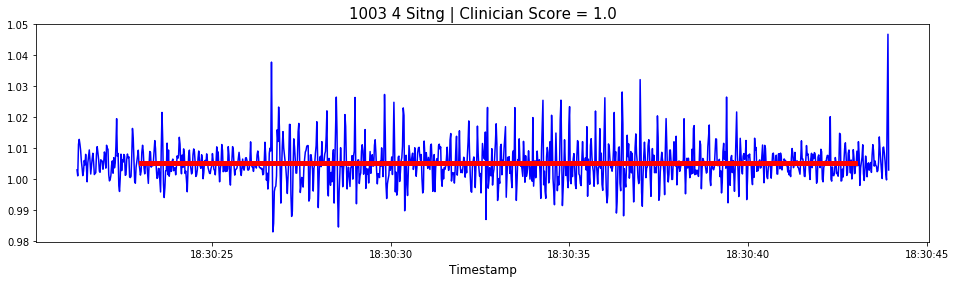

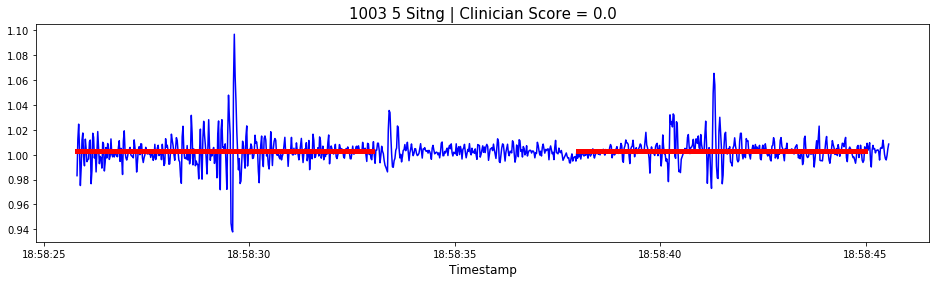

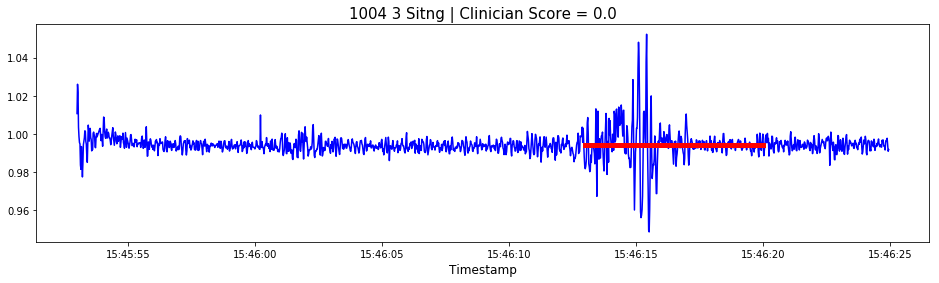

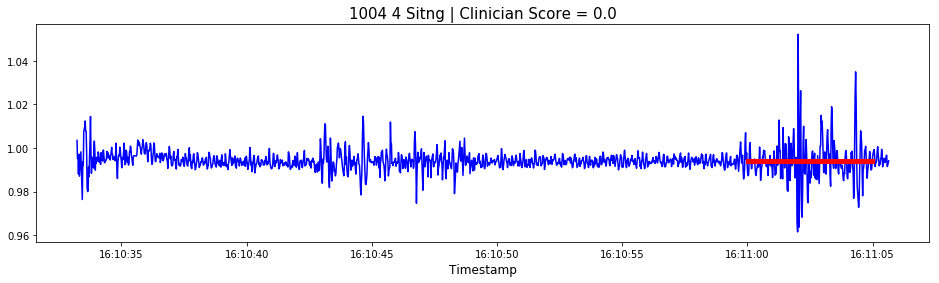

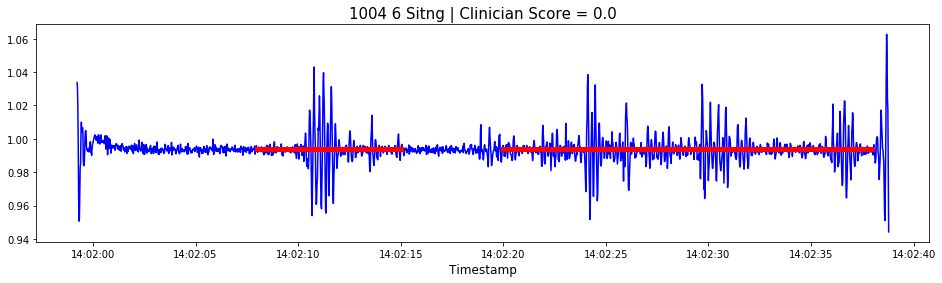

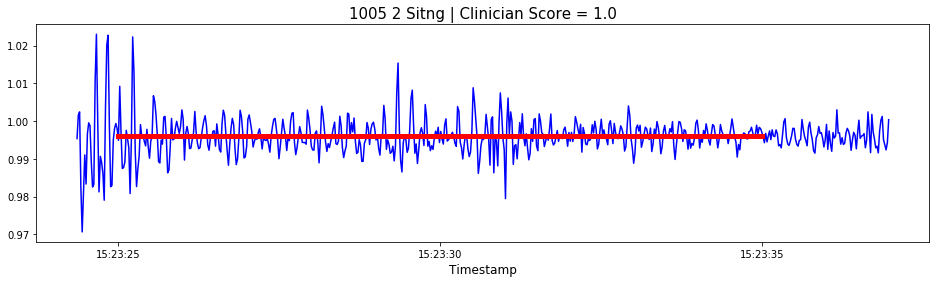

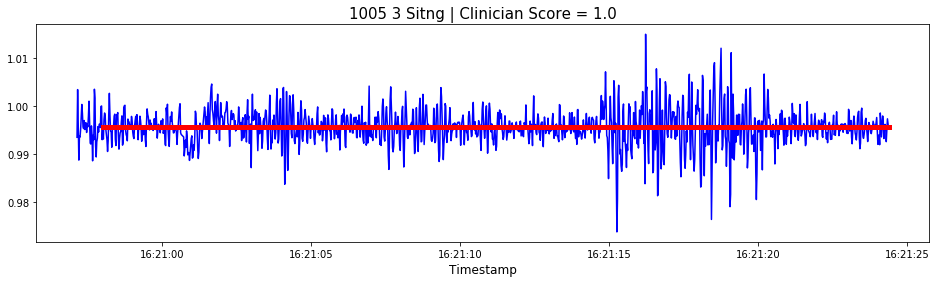

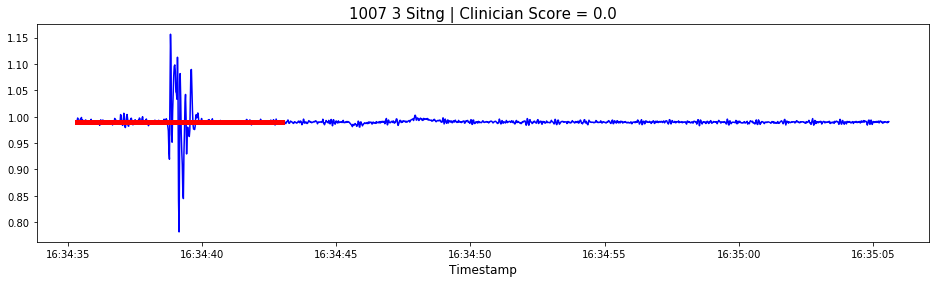

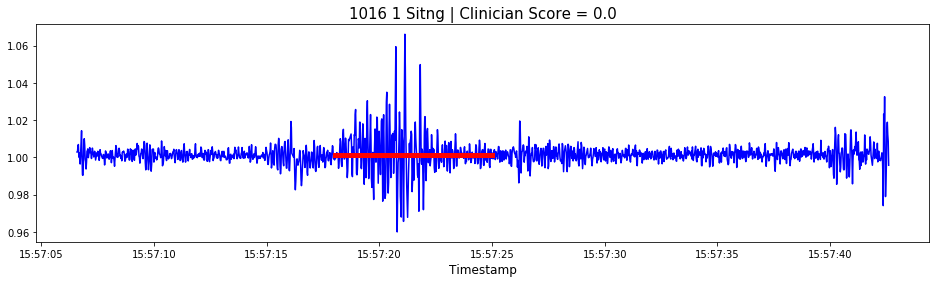

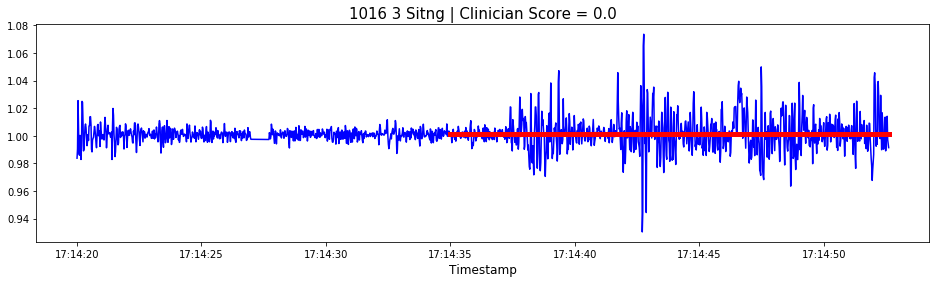

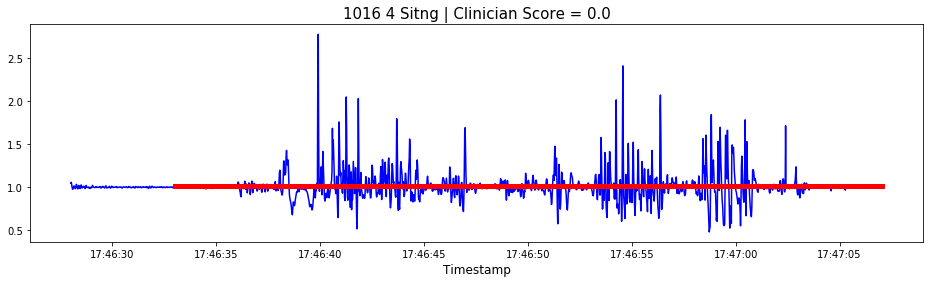

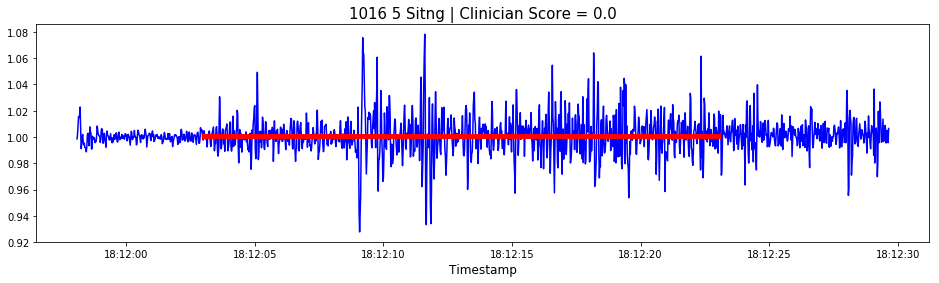

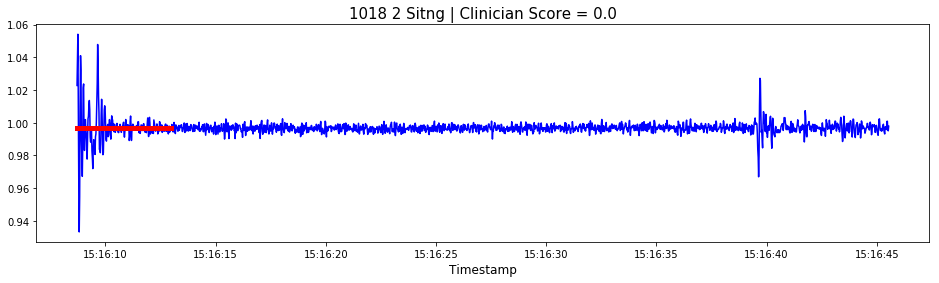

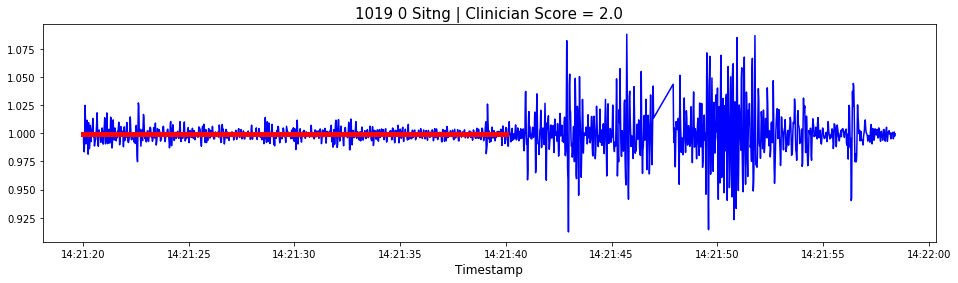

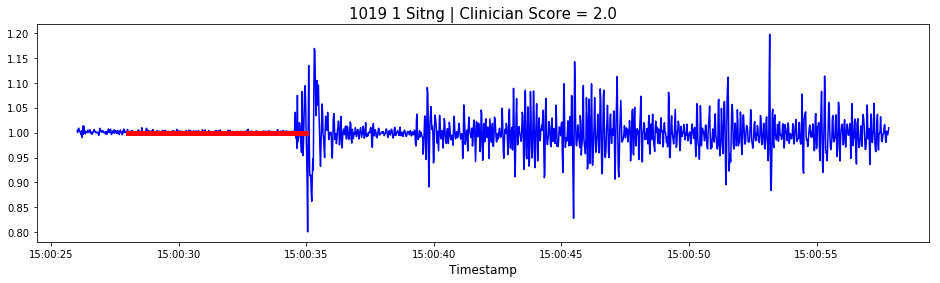

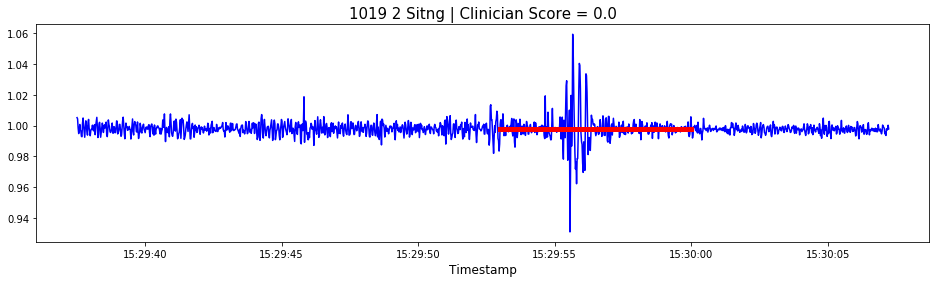

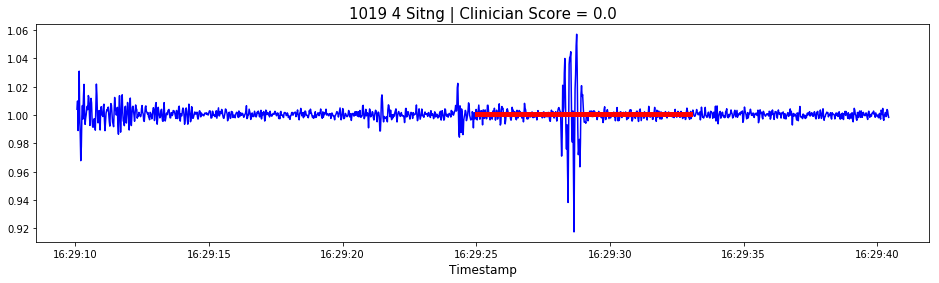

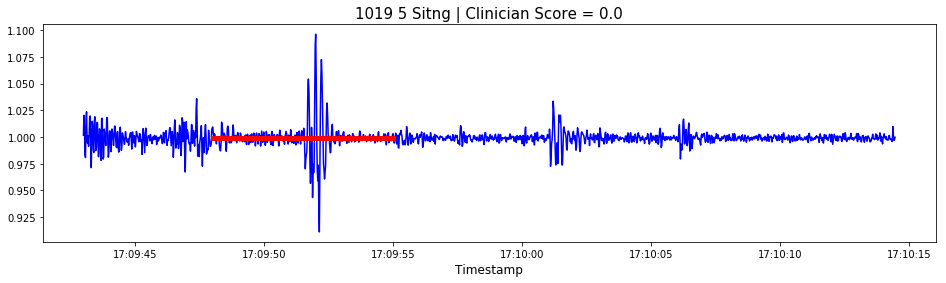

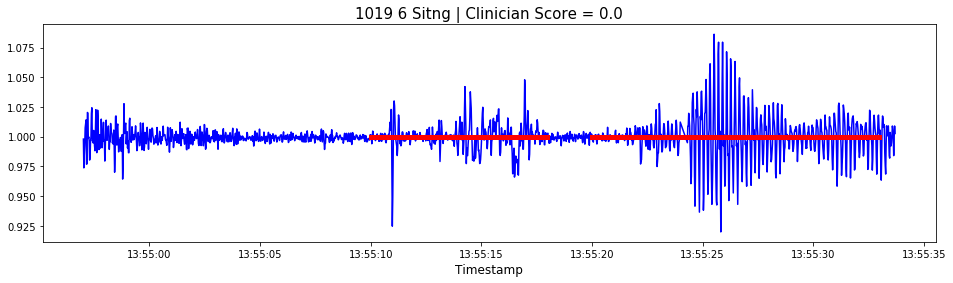

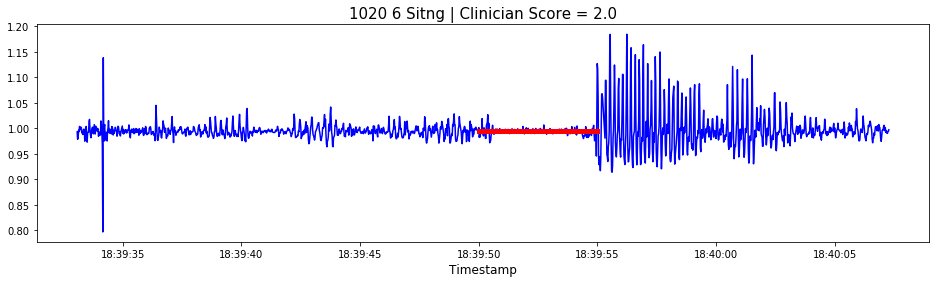

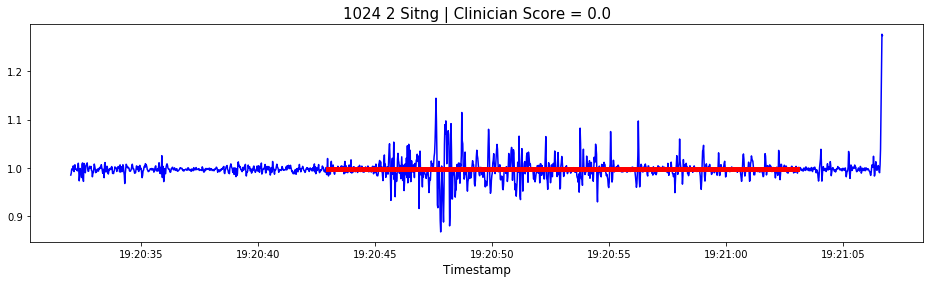

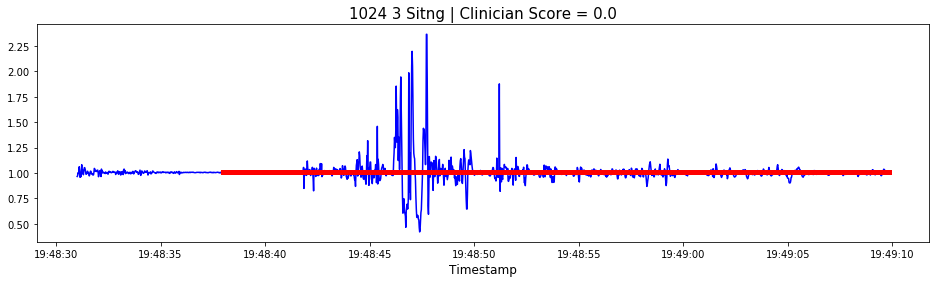

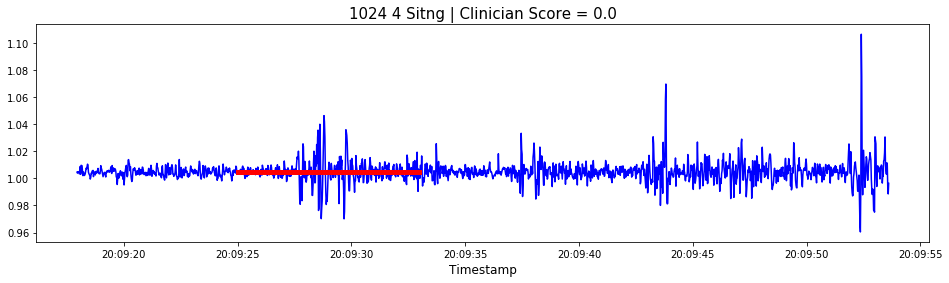

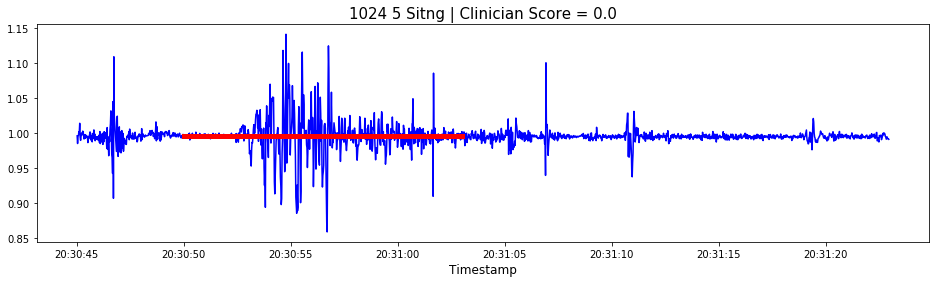

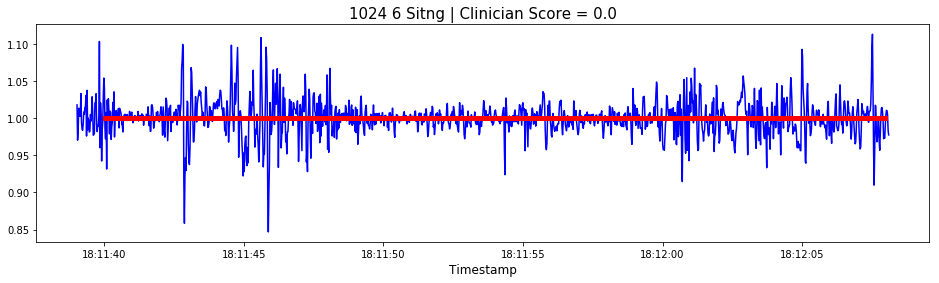

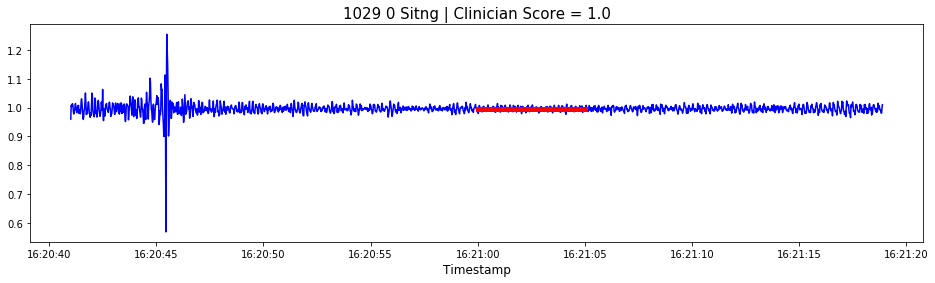

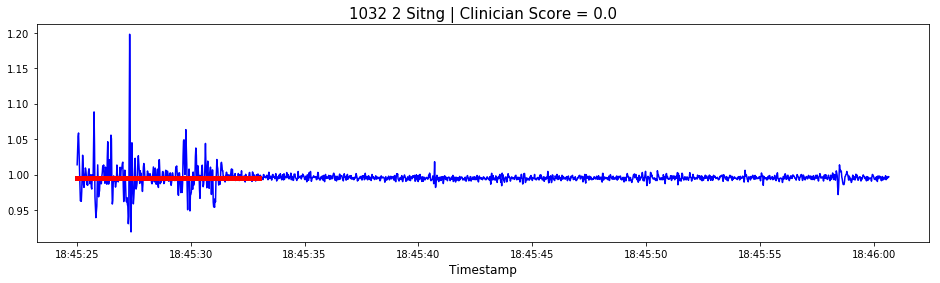

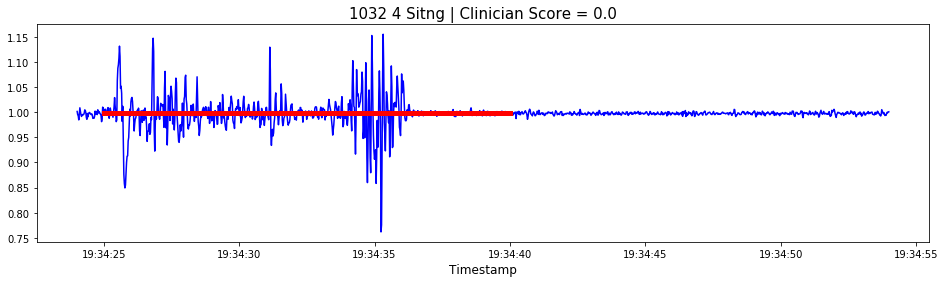

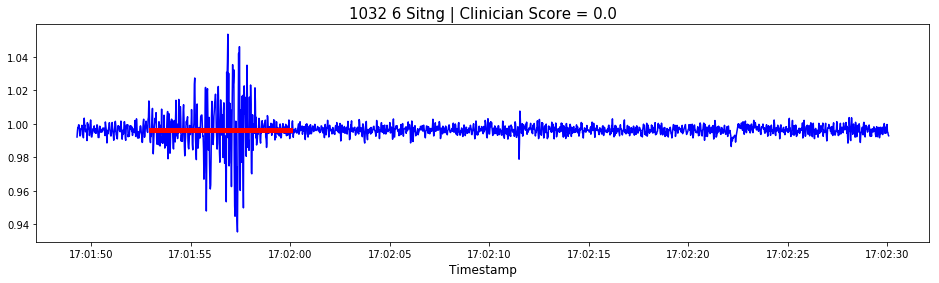

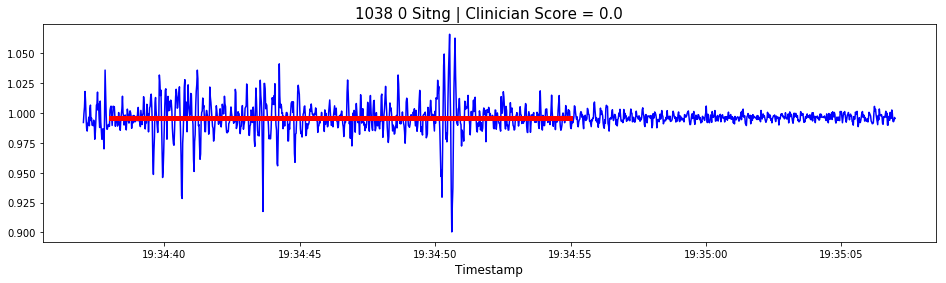

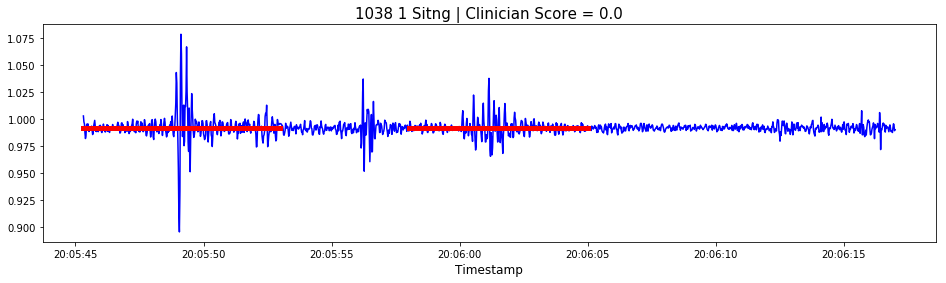

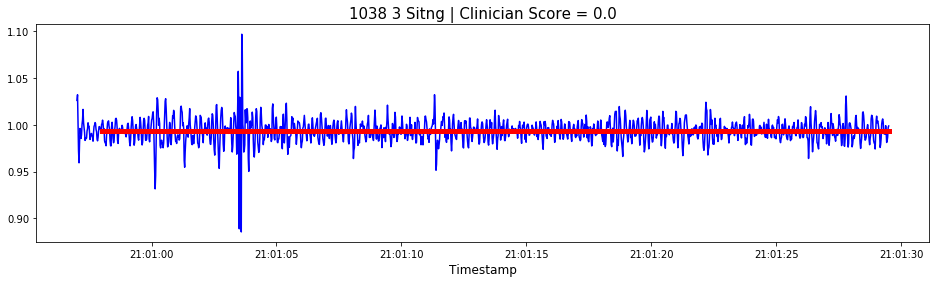

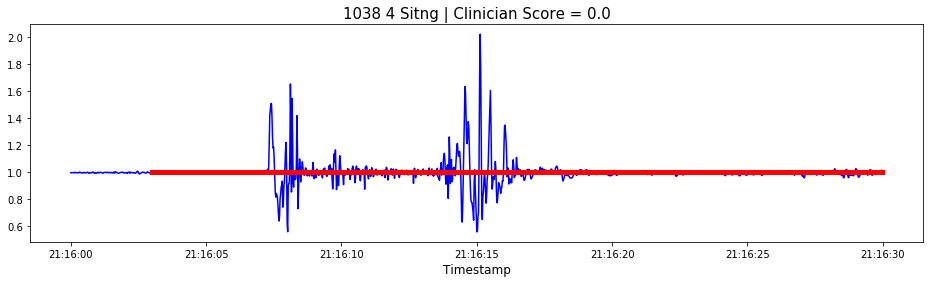

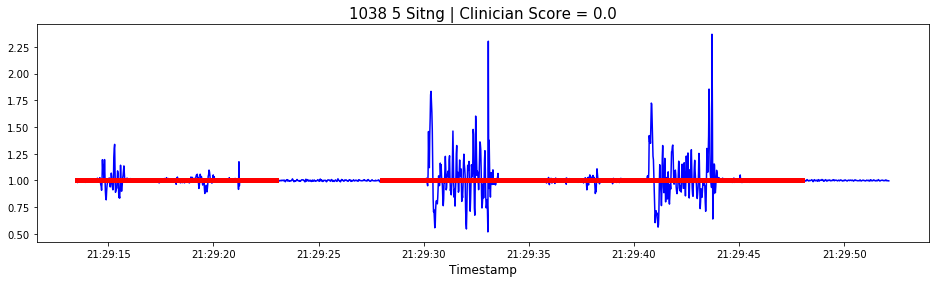

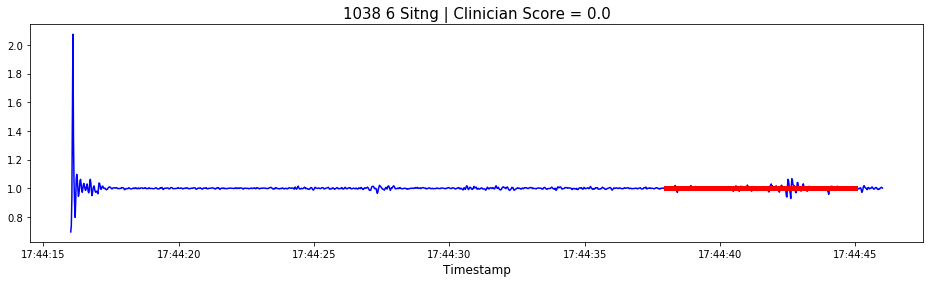

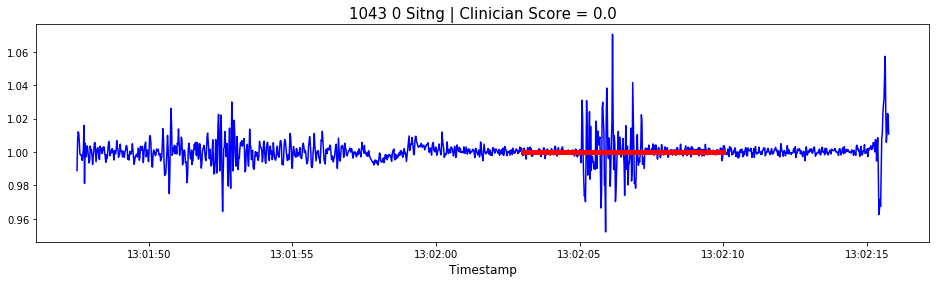

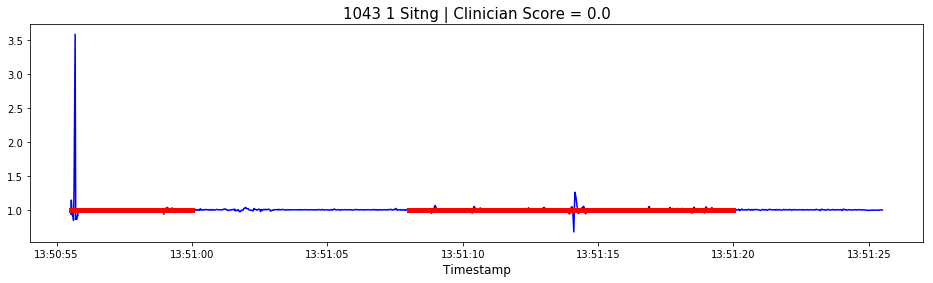

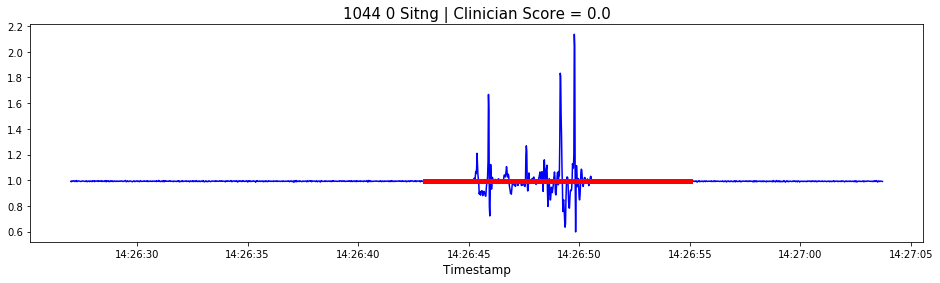

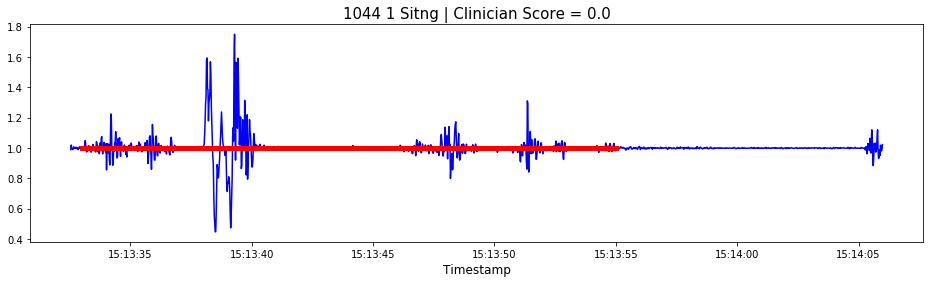

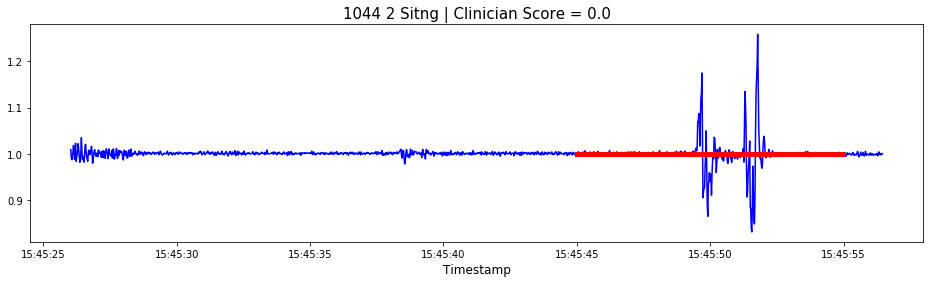

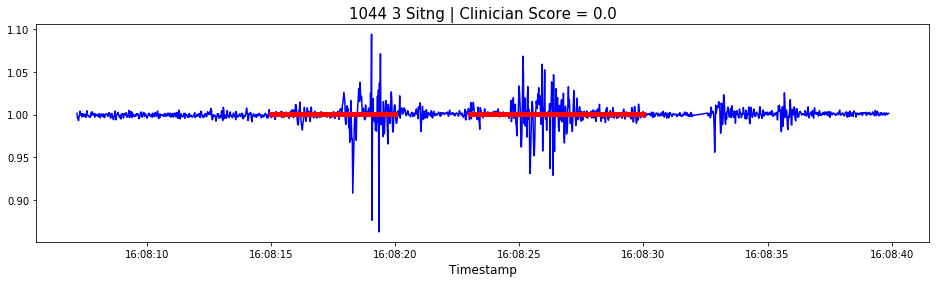

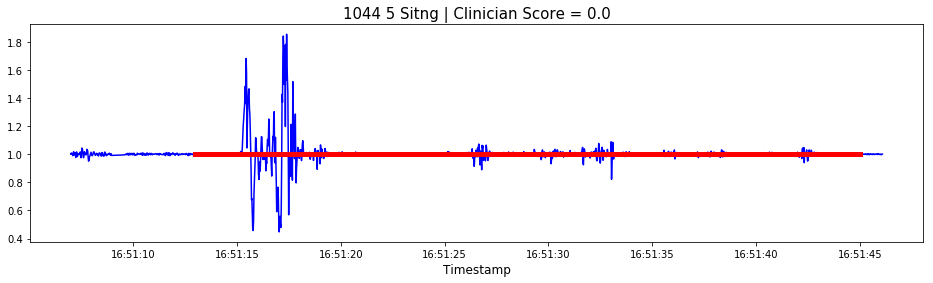

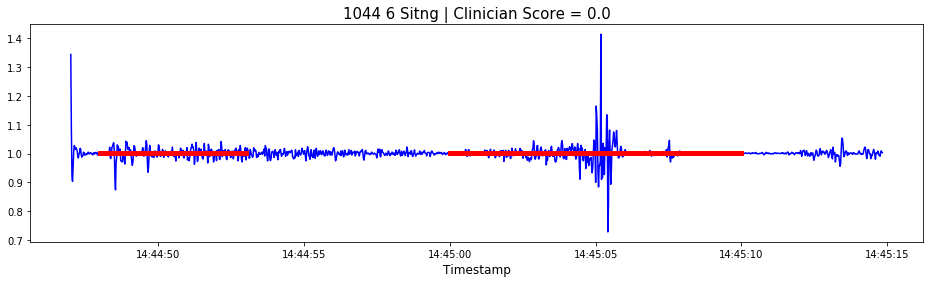

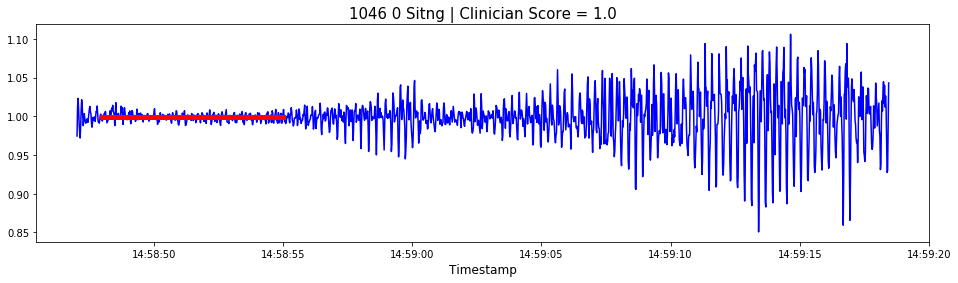

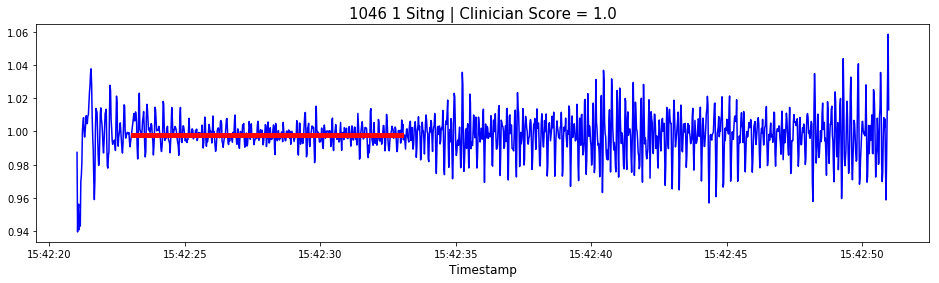

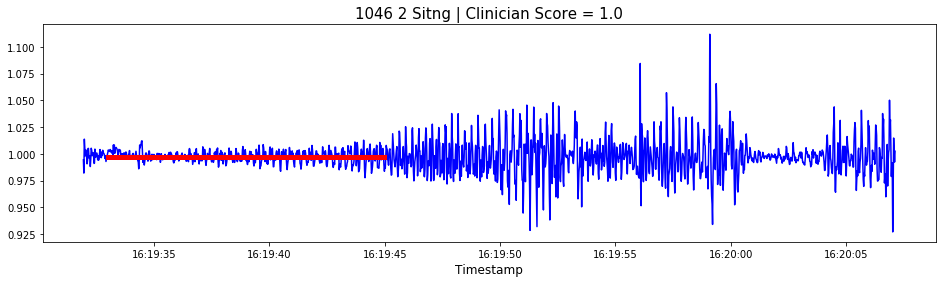

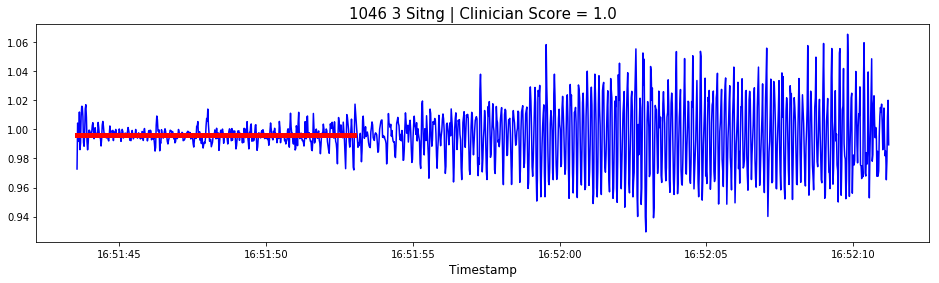

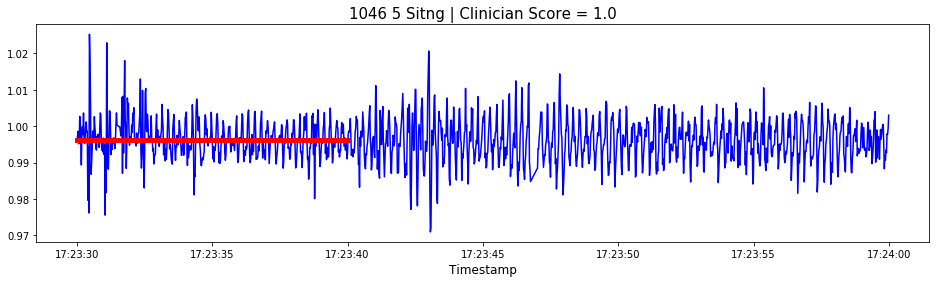

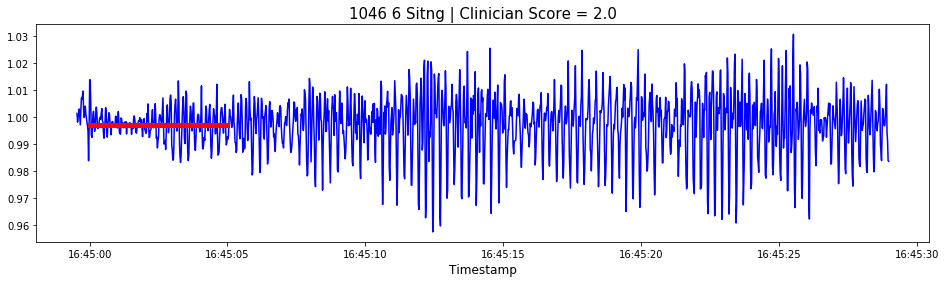

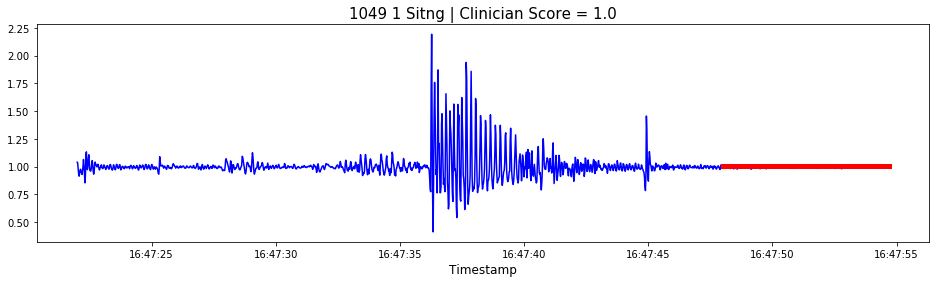

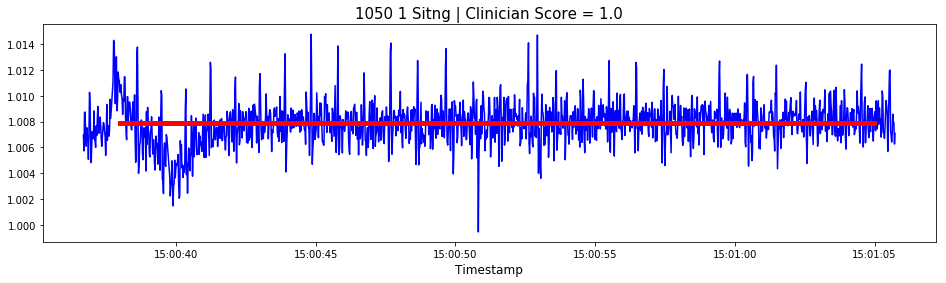

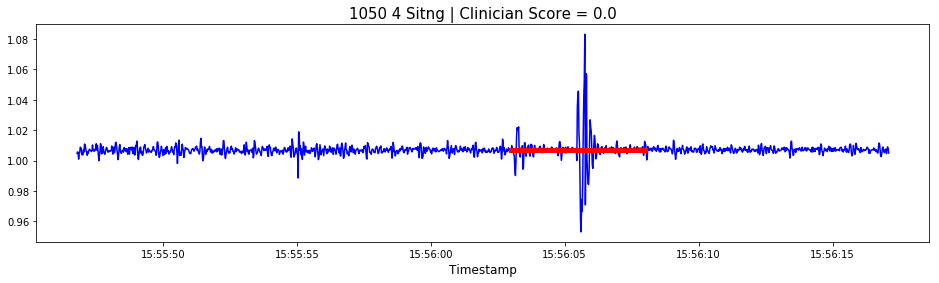

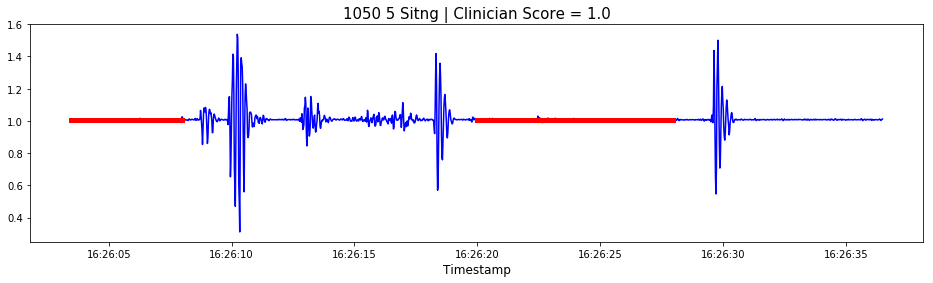

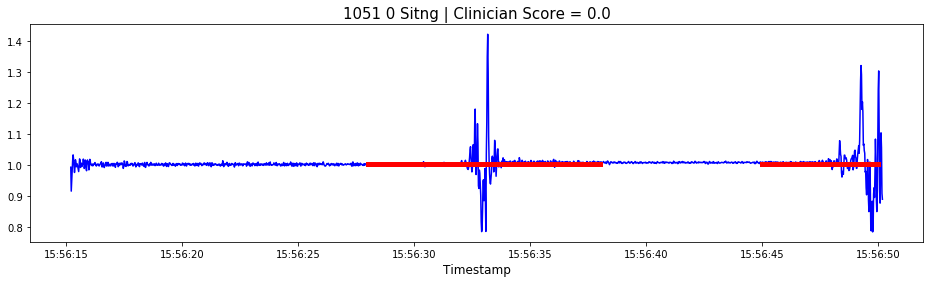

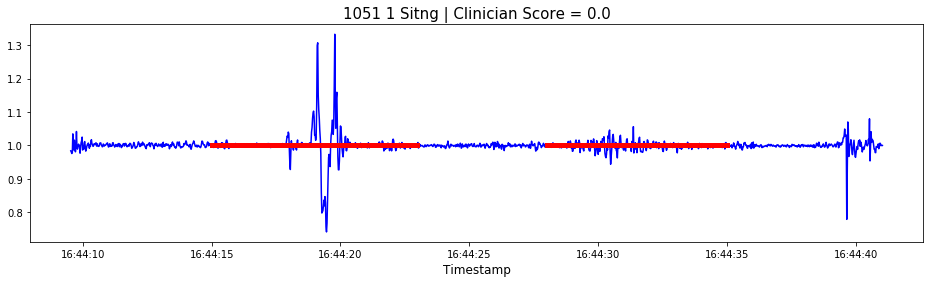

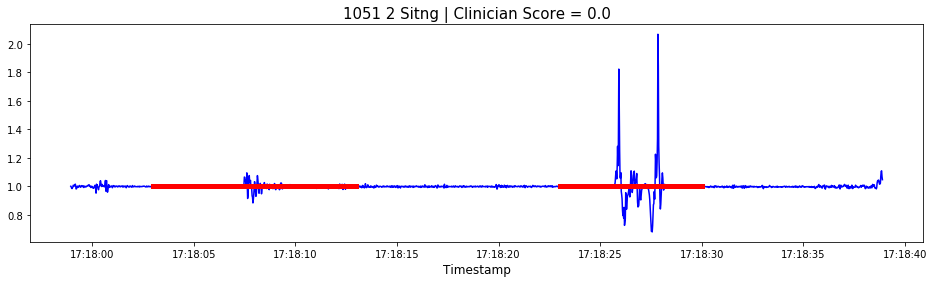

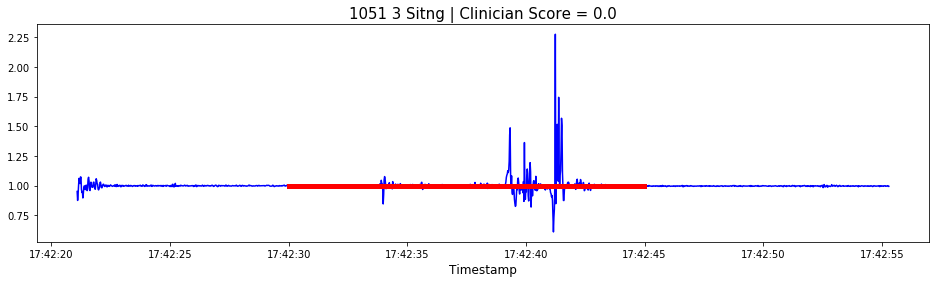

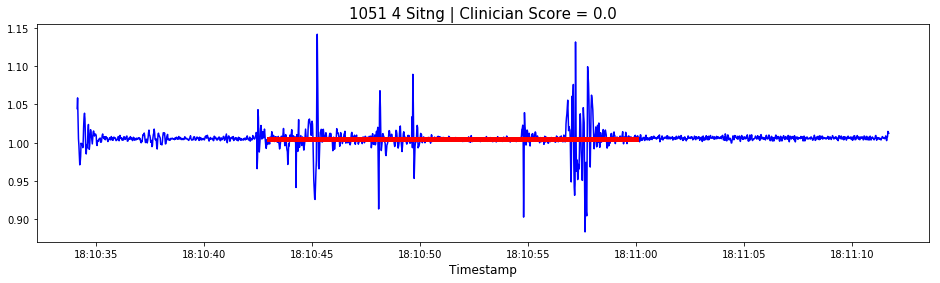

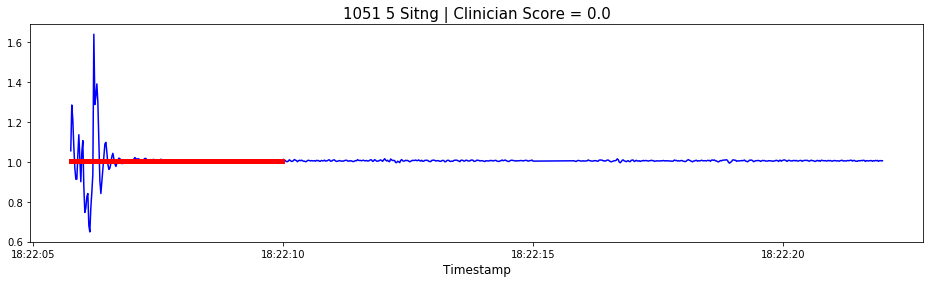

In [38]:
# plot all full task signals containing clips thought to be attached to an improper score for tremor
SitngClipFreq, SitngTaskPred, SitngAUC = scoreTremFFT(ClinicFreqData_max, 'Sitng', '4-8', False)
FalseLabClips = SitngClipFreq[SitngClipFreq.FFTscore != SitngClipFreq.Tremor.apply(lambda x: 1 if x > 0 else x)]
for sub in FalseLabClips.SubjID.unique():
    SFalseLab = FalseLabClips[FalseLabClips.SubjID == sub]
    for visit in SFalseLab.Visit.unique():
        SVFalseLab = SFalseLab[SFalseLab.Visit == visit]
        accdata = pd.read_csv(os.path.join(path, 'TaskAcc', 
                                           str(sub) + '_' + str(visit) + '_' + SVFalseLab.TaskAbb.iloc[-1] + '.csv'), 
                              parse_dates = ['timestamp'])[['timestamp', 'x', 'y', 'z']]
#         accdata.loc[:, ['x', 'y', 'z']] = filterdata(accdata[['x', 'y', 'z']])
        acc_mag = np.sqrt((accdata.x)**2 + (accdata.y)**2 + (accdata.z)**2)
        SVClips = pd.DataFrame()
        plt.figure(figsize = (16, 4))
        plt.plot(accdata.timestamp, acc_mag, 'b')
        for clip in SVFalseLab.iterrows():
            clipacc = pd.read_csv(os.path.join(dest, 'Clinic Data', 'Feature Clips', 
                                                str(sub) + '_' + str(visit) + '_' + 
                                                clip[1]['TaskAbb'] + '_' + str(clip[1]['Clip']) + '.csv'), 
                                   parse_dates = ['Timestamp'])[['Timestamp']]
            plt.plot(clipacc.values, [np.mean(acc_mag)] * len(clipacc.values), 'r', linewidth = 5)
        plt.xlabel('Timestamp', fontsize = 12)
        plt.title(str(sub) + ' ' + str(visit) + ' ' + SVFalseLab.TaskAbb.iloc[-1] + ' | '
                  'Clinician Score = ' + str(SVFalseLab.Tremor.iloc[-1]), fontsize = 15)
        plt.show()
        
# red line indicates position of 'falsely labeled' clips of the data